# Análise de Dispêndios e Quadrantes de Decisão - Lei do Bem

## 1. Configuração e Conexão com Banco de Dados

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

# Carregar dados do CSV
print("Carregando dados do CSV...")
df = pd.read_csv('./csv_longo/perguntas2508.csv', sep=';')

print(f"\n{'='*73}")
print("DADOS CARREGADOS")
print(f"{'='*73}")
print(f"Total de registros: {len(df):,}")
print(f"Total de colunas: {len(df.columns)}")
print(f"\nColunas disponíveis:")
print(df.columns.tolist())

Carregando dados do CSV...

DADOS CARREGADOS
Total de registros: 2,831,160
Total de colunas: 29

Colunas disponíveis:
['id_empresa_ano', 'ano_referencia', 'setor', 'nrcnpj', 'norazaosocial', 'iddadoanaliseprojeto', 'do_resultado_analise', 'p_resultado_analise', 'vlreceitaliquida', 'valortotalproj', 'valordoutorproj', 'quantdoutorproj', 'valormestreproj', 'quantmestreproj', 'valorrhproj', 'quantrhproj', 'valorictproj', 'valoruniversidadesproj', 'valorservterceirosproj', 'percservterceirosproj', 'quantpessoalempresa', 'percpessoalalocadoempresa', 'quantdoutorempresa', 'quantmestreempresa', 'valortotalempresa', 'valorserterceirosempresa', 'percservterceirosempresa', 'valorbensequipempresa', 'percbensequipempresa']


## 2. Pré-processamento e Criação dos Quadrantes

Classificação dos quadrantes:

    Q1: Ministério Recomenda, Pesquisador Recomenda
    Q2: Ministério Não Recomenda, Pesquisador Recomenda
    Q3: Ministério Recomenda, Pesquisador Não Recomenda
    Q4: Ministério Não Recomenda, Pesquisador Não Recomenda

In [47]:
# Agregar por projeto (pegar primeira ocorrência já que os dados estão agregados)
df_projetos = df.groupby('iddadoanaliseprojeto').first().reset_index()

# Filtrar anos relevantes (2018-2023)
df_projetos = df_projetos[df_projetos['ano_referencia'].isin([2018, 2019, 2020, 2021, 2022, 2023])]

def classificar_quadrante(row):
    """
    Classifica projetos nos 4 quadrantes:
    S/S: Ministério Recomenda, Pesquisador Recomenda
    S/N: Ministério Não Recomenda, Pesquisador Recomenda
    N/S: Ministério Recomenda, Pesquisador Não Recomenda
    N/N: Ministério Não Recomenda, Pesquisador Não Recomenda
    """
    do_result = str(row['do_resultado_analise']).strip().lower() if pd.notna(row['do_resultado_analise']) else ''
    p_result = str(row['p_resultado_analise']).strip().lower() if pd.notna(row['p_resultado_analise']) else ''
    
    if not do_result or not p_result:
        return np.nan
    
    # DO = Pesquisador, P = Ministério
    do_rec = 'recomendado' in do_result and 'não' not in do_result
    p_rec = 'recomendado' in p_result and 'não' not in p_result
    
    if p_rec and do_rec:
        return 'S/S'  # Ambos recomendam
    elif not p_rec and do_rec:
        return 'S/N'  # Ministério não, Pesquisador sim
    elif p_rec and not do_rec:
        return 'N/S'  # Ministério sim, Pesquisador não
    else:
        return 'N/N'  # Ambos não recomendam

# Criar variáveis binárias para análise
df_projetos['quadrante'] = df_projetos.apply(classificar_quadrante, axis=1)
df_projetos['ministerio_aprova'] = df_projetos['p_resultado_analise'].str.contains('Recomendado', case=False, na=False) & \
                                    ~df_projetos['p_resultado_analise'].str.contains('Não', case=False, na=False)
df_projetos['pesquisador_aprova'] = df_projetos['do_resultado_analise'].str.contains('Recomendado', case=False, na=False) & \
                                     ~df_projetos['do_resultado_analise'].str.contains('Não', case=False, na=False)

# Remover NaN dos quadrantes
df_analise = df_projetos.dropna(subset=['quadrante']).copy()

print(f"\n{'='*73}")
print("DISTRIBUIÇÃO DOS QUADRANTES")
print(f"{'='*73}")
dist = df_analise['quadrante'].value_counts(normalize=True) * 100
for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    if q in dist.index:
        print(f"{q}: {dist[q]:.1f}% ({df_analise['quadrante'].value_counts()[q]} projetos)")


DISTRIBUIÇÃO DOS QUADRANTES
S/S: 53.8% (36471 projetos)
S/N: 7.5% (5104 projetos)
N/S: 8.7% (5914 projetos)
N/N: 29.9% (20294 projetos)


## 3. Análise 1: Regressão Logística - Valor do Projeto vs Quadrantes

Esta análise investiga se o valor financeiro total de um projeto (valortotalproj) influencia sua probabilidade de ser classificado em cada um dos quatro quadrantes de decisão. A regressão logística foi escolhida porque é a técnica estatística apropriada quando queremos predizer uma variável categórica binária (estar ou não em determinado quadrante) a partir de uma variável contínua (valor do projeto).

O **coeficiente** indica a direção e magnitude da relação - valores positivos significam que aumentos no valor do projeto aumentam a probabilidade de estar naquele quadrante. O **Odds Ratio** quantifica esse efeito de forma interpretável: um OR de 1.02 significa que cada aumento de um desvio padrão no valor do projeto aumenta em 2% as chances de estar naquele quadrante. O **Score** representa a acurácia do modelo, ou seja, o percentual de classificações corretas. O **p-value** testa a significância estatística - valores abaixo de 0.05 indicam que a relação encontrada provavelmente não ocorreu por acaso, sendo estatisticamente confiável.


ANÁLISE 1: REGRESSÃO LOGÍSTICA - VALOR DO PROJETO VS QUADRANTES

-------------------------------------------------------------------------
REGRESSÃO LOGÍSTICA PARA S/S
-------------------------------------------------------------------------
Coeficiente: 0.0198
Odds Ratio: 1.0200
Score (acurácia): 0.5381
P-value: 1.5059e-02

-------------------------------------------------------------------------
REGRESSÃO LOGÍSTICA PARA S/N
-------------------------------------------------------------------------
Coeficiente: 0.0240
Odds Ratio: 1.0243
Score (acurácia): 0.9247
P-value: 3.7396e-02

-------------------------------------------------------------------------
REGRESSÃO LOGÍSTICA PARA N/S
-------------------------------------------------------------------------
Coeficiente: -0.2020
Odds Ratio: 0.8171
Score (acurácia): 0.9128
P-value: 5.8089e-12

-------------------------------------------------------------------------
REGRESSÃO LOGÍSTICA PARA N/N
--------------------------------------------

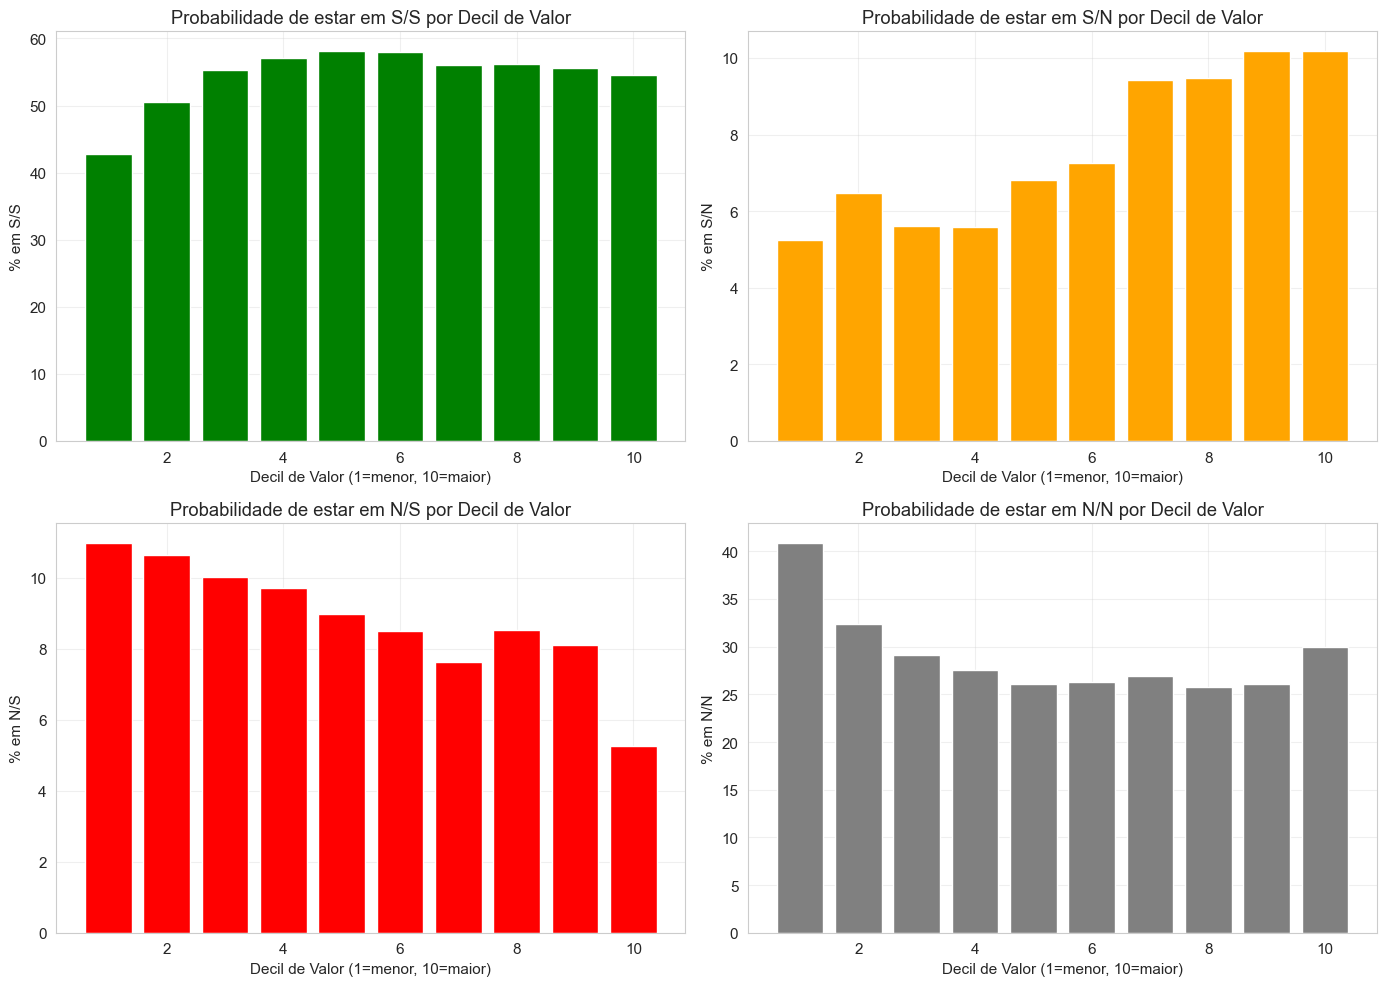


RESUMO DA ANÁLISE 1
S/S: Significativo? SIM | Direção: POSITIVA | Odds Ratio: 1.020
S/N: Significativo? SIM | Direção: POSITIVA | Odds Ratio: 1.024
N/S: Significativo? SIM | Direção: NEGATIVA | Odds Ratio: 0.817
N/N: Significativo? NÃO | Direção: NEGATIVA | Odds Ratio: 0.999


In [72]:
print(f"\n{'='*73}")
print("ANÁLISE 1: REGRESSÃO LOGÍSTICA - VALOR DO PROJETO VS QUADRANTES")
print(f"{'='*73}")

# Preparar dados para regressão
X = df_analise[['valortotalproj']].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# Criar variáveis dummy para cada quadrante
for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    df_analise[f'is_{q.replace("/", "_")}'] = (df_analise['quadrante'] == q).astype(int)

# Realizar regressão logística para cada quadrante
resultados_regressao = {}

for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    print(f"\n{'-'*73}")
    print(f"REGRESSÃO LOGÍSTICA PARA {q}")
    print(f"{'-'*73}")
    
    y = df_analise[f'is_{q.replace("/", "_")}']
    
    # Treinar modelo
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_scaled, y)
    
    # Coeficiente e odds ratio
    coef = model.coef_[0][0]
    odds_ratio = np.exp(coef)
    
    # Score do modelo
    score = model.score(X_scaled, y)
    
    # Calcular p-value
    from scipy.stats import norm
    n = len(X_scaled)
    predictions = model.predict_proba(X_scaled)[:, 1]
    V = np.sum((predictions * (1 - predictions))[:, np.newaxis] * (X_scaled ** 2))
    se = np.sqrt(1 / V) if V > 0 else 1
    z_score = coef / se
    p_value = 2 * (1 - norm.cdf(np.abs(z_score)))
    
    resultados_regressao[q] = {
        'coeficiente': coef,
        'odds_ratio': odds_ratio,
        'score': score,
        'p_value': float(p_value)
    }
    
    print(f"Coeficiente: {coef:.4f}")
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"Score (acurácia): {score:.4f}")
    print(f"P-value: {float(p_value):.4e}")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, q in enumerate(['S/S', 'S/N', 'N/S', 'N/N']):
    df_vis = df_analise.copy()
    df_vis['valor_bin'] = pd.qcut(df_vis['valortotalproj'], q=10, labels=range(1, 11), duplicates='drop')
    prop_by_bin = df_vis.groupby('valor_bin')[f'is_{q.replace("/", "_")}'].mean() * 100
    
    axes[i].bar(prop_by_bin.index, prop_by_bin.values, 
                color=['green' if q=='S/S' else 'orange' if q=='S/N' else 'red' if q=='N/S' else 'gray'][0])
    axes[i].set_title(f'Probabilidade de estar em {q} por Decil de Valor')
    axes[i].set_xlabel('Decil de Valor (1=menor, 10=maior)')
    axes[i].set_ylabel(f'% em {q}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Resumo
print(f"\n{'='*73}")
print("RESUMO DA ANÁLISE 1")
print(f"{'='*73}")
for q, res in resultados_regressao.items():
    sig = "SIM" if res['p_value'] < 0.05 else "NÃO"
    direção = "POSITIVA" if res['coeficiente'] > 0 else "NEGATIVA"
    print(f"{q}: Significativo? {sig} | Direção: {direção} | Odds Ratio: {res['odds_ratio']:.3f}")

## 4. Análise 2: ICT e Probabilidade por Quadrante

Esta análise examina como a presença de investimento em Instituições de Ciência e Tecnologia (ICTs) afeta a distribuição dos projetos entre os quadrantes. Utiliza-se o teste qui-quadrado para verificar se existe associação significativa entre ter ICT (variável categórica binária) e o quadrante resultante (variável categórica).

O **Risco Relativo** compara diretamente as probabilidades - um RR de 1.48 para S/S significa que projetos com ICT têm 48% mais chance de receber dupla aprovação comparado aos projetos sem ICT. A **diferença em pontos percentuais** mostra o impacto absoluto, enquanto o **p-value do teste qui-quadrado** confirma se essa diferença é estatisticamente significativa ou poderia ter ocorrido por acaso.


ANÁLISE 2: IMPACTO DE ICT NA PROBABILIDADE POR QUADRANTE
Projetos com ICT: 7,472 (11.0%)
Projetos sem ICT: 60,311 (89.0%)

------------------------------------------------------------
PROBABILIDADE DE CADA QUADRANTE COM/SEM ICT
------------------------------------------------------------

S/S:
  Com ICT: 75.4%
  Sem ICT: 51.1%
  Diferença: +24.3 pontos percentuais
  Risco Relativo: 1.48
  P-value (χ²): 0.0000
  ✓ Ter ICT AUMENTA significativamente a probabilidade de S/S

S/N:
  Com ICT: 4.3%
  Sem ICT: 7.9%
  Diferença: -3.6 pontos percentuais
  Risco Relativo: 0.55
  P-value (χ²): 0.0000
  ✓ Ter ICT DIMINUI significativamente a probabilidade de S/N

N/S:
  Com ICT: 7.5%
  Sem ICT: 8.9%
  Diferença: -1.3 pontos percentuais
  Risco Relativo: 0.85
  P-value (χ²): 0.0001
  ✓ Ter ICT DIMINUI significativamente a probabilidade de N/S

N/N:
  Com ICT: 12.7%
  Sem ICT: 32.1%
  Diferença: -19.4 pontos percentuais
  Risco Relativo: 0.40
  P-value (χ²): 0.0000
  ✓ Ter ICT DIMINUI significativam

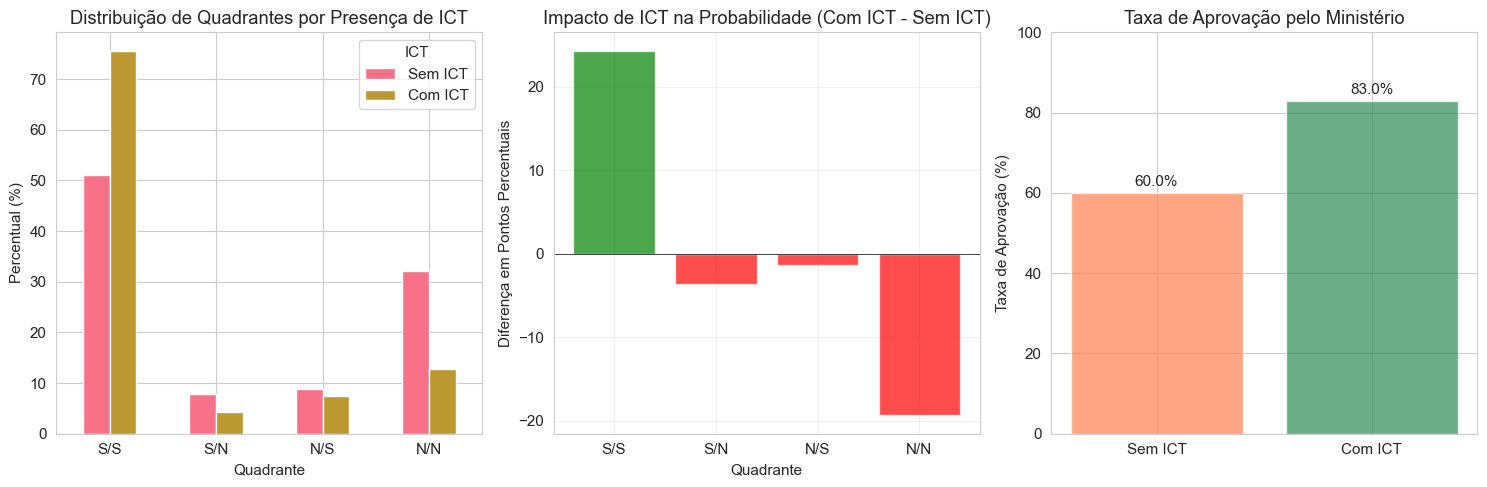

In [71]:
print(f"\n{'='*73}")
print("ANÁLISE 2: IMPACTO DE ICT NA PROBABILIDADE POR QUADRANTE")
print(f"{'='*73}")

# Criar variável binária para ICT
df_analise['tem_ict'] = (df_analise['valorictproj'] > 0).astype(int)

# Estatísticas gerais
total_com_ict = df_analise['tem_ict'].sum()
pct_com_ict = df_analise['tem_ict'].mean() * 100

print(f"Projetos com ICT: {total_com_ict:,} ({pct_com_ict:.1f}%)")
print(f"Projetos sem ICT: {len(df_analise) - total_com_ict:,} ({100-pct_com_ict:.1f}%)")

# Análise de probabilidade por quadrante
print(f"\n{'-'*60}")
print("PROBABILIDADE DE CADA QUADRANTE COM/SEM ICT")
print(f"{'-'*60}")

# Tabela de contingência
for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    prob_com_ict = df_analise[df_analise['tem_ict'] == 1]['quadrante'].value_counts(normalize=True).get(q, 0) * 100
    prob_sem_ict = df_analise[df_analise['tem_ict'] == 0]['quadrante'].value_counts(normalize=True).get(q, 0) * 100
    
    contingency = pd.crosstab(df_analise['tem_ict'], df_analise['quadrante'] == q)
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    risco_relativo = prob_com_ict / prob_sem_ict if prob_sem_ict > 0 else np.inf
    
    print(f"\n{q}:")
    print(f"  Com ICT: {prob_com_ict:.1f}%")
    print(f"  Sem ICT: {prob_sem_ict:.1f}%")
    print(f"  Diferença: {prob_com_ict - prob_sem_ict:+.1f} pontos percentuais")
    print(f"  Risco Relativo: {risco_relativo:.2f}")
    print(f"  P-value (χ²): {p_value:.4f}")
    
    if p_value < 0.05:
        if prob_com_ict > prob_sem_ict:
            print(f"  ✓ Ter ICT AUMENTA significativamente a probabilidade de {q}")
        else:
            print(f"  ✓ Ter ICT DIMINUI significativamente a probabilidade de {q}")
    else:
        print(f"  ✗ ICT não tem efeito significativo em {q}")

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico 1: Distribuição geral
quadrante_ict = pd.crosstab(df_analise['quadrante'], df_analise['tem_ict'], normalize='columns') * 100
quadrante_ict = quadrante_ict.sort_index(ascending=False)
quadrante_ict.plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribuição de Quadrantes por Presença de ICT')
axes[0].set_xlabel('Quadrante')
axes[0].set_ylabel('Percentual (%)')
axes[0].legend(title='ICT', labels=['Sem ICT', 'Com ICT'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Gráfico 2: Diferença absoluta
diffs = []
for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    prob_com = df_analise[df_analise['tem_ict'] == 1]['quadrante'].value_counts(normalize=True).get(q, 0) * 100
    prob_sem = df_analise[df_analise['tem_ict'] == 0]['quadrante'].value_counts(normalize=True).get(q, 0) * 100
    diffs.append(prob_com - prob_sem)

colors = ['green' if d > 0 else 'red' for d in diffs]
axes[1].bar(['S/S', 'S/N', 'N/S', 'N/N'], diffs, color=colors, alpha=0.7)
axes[1].set_title('Impacto de ICT na Probabilidade (Com ICT - Sem ICT)')
axes[1].set_xlabel('Quadrante')
axes[1].set_ylabel('Diferença em Pontos Percentuais')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# Gráfico 3: Taxa de aprovação
aprovacao_com_ict = df_analise[df_analise['tem_ict'] == 1]['ministerio_aprova'].mean() * 100
aprovacao_sem_ict = df_analise[df_analise['tem_ict'] == 0]['ministerio_aprova'].mean() * 100

bars = axes[2].bar(['Sem ICT', 'Com ICT'], [aprovacao_sem_ict, aprovacao_com_ict], 
                   color=['coral', 'seagreen'], alpha=0.7)
axes[2].set_title('Taxa de Aprovação pelo Ministério')
axes[2].set_ylabel('Taxa de Aprovação (%)')
axes[2].set_ylim(0, 100)

for bar, val in zip(bars, [aprovacao_sem_ict, aprovacao_com_ict]):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Análise 3: Doutores/Mestres e Aprovação

Esta análise investiga se a presença de profissionais altamente qualificados (doutores e mestres) aumenta as chances de aprovação tanto pelo Ministério quanto pelo pesquisador DO. Combina duas abordagens: análise categórica (tem/não tem) usando teste qui-quadrado, e análise contínua (quantidade) usando regressão logística.

O **coeficiente de regressão** quantifica o impacto de cada doutor ou mestre adicional na probabilidade de aprovação. A comparação entre **taxas de aprovação com e sem qualificação** fornece uma visão intuitiva do impacto, enquanto o **p-value** confirma a significância estatística dessa diferença.


ANÁLISE 3: IMPACTO DE DOUTORES E MESTRES NA APROVAÇÃO

ANÁLISE PARA DOUTORES
------------------------------------------------------------

Aprovação pelo Ministério:
  Taxa aprovação COM doutor: 76.6%
  Taxa aprovação SEM doutor: 59.9%
  Diferença: +16.7 pp
  P-value: 0.0000
  Coeficiente regressão (por doutor adicional): 0.4098
  ✓ Ter doutores AUMENTA significativamente a aprovação pelo Ministério

Aprovação pelo Pesquisador DO:
  Taxa aprovação COM doutor: 76.7%
  Taxa aprovação SEM doutor: 58.4%
  Diferença: +18.2 pp
  P-value: 0.0000
  Coeficiente regressão (por doutor adicional): 0.4394
  ✓ Ter doutores AUMENTA significativamente a aprovação pelo Pesquisador DO

ANÁLISE PARA MESTRES
------------------------------------------------------------

Aprovação pelo Ministério:
  Taxa aprovação COM mestre: 71.8%
  Taxa aprovação SEM mestre: 57.1%
  Diferença: +14.7 pp
  P-value: 0.0000
  Coeficiente regressão (por mestre adicional): 0.3018
  ✓ Ter mestres AUMENTA significativamente a ap

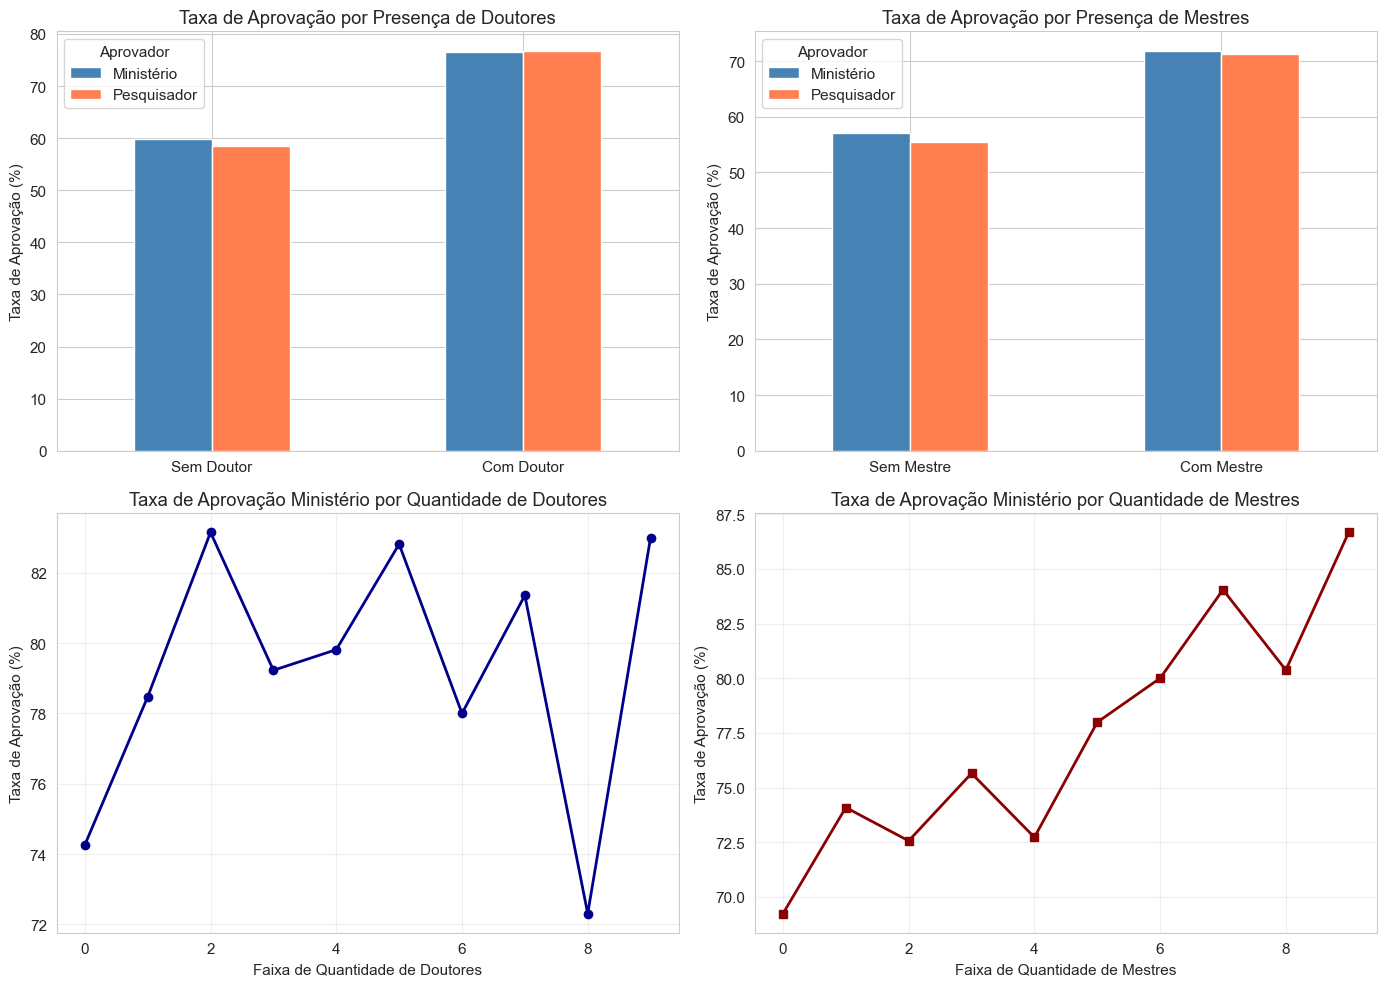

In [70]:
print(f"\n{'='*73}")
print("ANÁLISE 3: IMPACTO DE DOUTORES E MESTRES NA APROVAÇÃO")
print(f"{'='*73}")

# Preparar dados
df_analise['tem_doutor'] = (df_analise['quantdoutorproj'] > 0).astype(int)
df_analise['tem_mestre'] = (df_analise['quantmestreproj'] > 0).astype(int)

# Análise para DOUTORES
print("\nANÁLISE PARA DOUTORES")
print("-"*60)

for aprovador, coluna in [('Ministério', 'ministerio_aprova'), ('Pesquisador DO', 'pesquisador_aprova')]:
    print(f"\nAprovação pelo {aprovador}:")
    
    # Taxa de aprovação com/sem doutor
    taxa_com_doutor = df_analise[df_analise['tem_doutor'] == 1][coluna].mean() * 100
    taxa_sem_doutor = df_analise[df_analise['tem_doutor'] == 0][coluna].mean() * 100
    
    # Teste estatístico
    contingency = pd.crosstab(df_analise['tem_doutor'], df_analise[coluna])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    # Regressão logística
    X_doutor = df_analise[['quantdoutorproj']].fillna(0)
    y = df_analise[coluna]
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(StandardScaler().fit_transform(X_doutor), y)
    coef_doutor = model.coef_[0][0]
    
    print(f"  Taxa aprovação COM doutor: {taxa_com_doutor:.1f}%")
    print(f"  Taxa aprovação SEM doutor: {taxa_sem_doutor:.1f}%")
    print(f"  Diferença: {taxa_com_doutor - taxa_sem_doutor:+.1f} pp")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Coeficiente regressão (por doutor adicional): {coef_doutor:.4f}")
    
    if p_value < 0.05:
        if taxa_com_doutor > taxa_sem_doutor:
            print(f"  ✓ Ter doutores AUMENTA significativamente a aprovação pelo {aprovador}")
        else:
            print(f"  ✓ Ter doutores DIMINUI significativamente a aprovação pelo {aprovador}")
    else:
        print(f"  ✗ Doutores não têm efeito significativo na aprovação pelo {aprovador}")

# Análise para MESTRES
print("\n" + "="*60)
print("ANÁLISE PARA MESTRES")
print("-"*60)

for aprovador, coluna in [('Ministério', 'ministerio_aprova'), ('Pesquisador DO', 'pesquisador_aprova')]:
    print(f"\nAprovação pelo {aprovador}:")
    
    # Taxa de aprovação com/sem mestre
    taxa_com_mestre = df_analise[df_analise['tem_mestre'] == 1][coluna].mean() * 100
    taxa_sem_mestre = df_analise[df_analise['tem_mestre'] == 0][coluna].mean() * 100
    
    # Teste estatístico
    contingency = pd.crosstab(df_analise['tem_mestre'], df_analise[coluna])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    # Regressão logística
    X_mestre = df_analise[['quantmestreproj']].fillna(0)
    y = df_analise[coluna]
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(StandardScaler().fit_transform(X_mestre), y)
    coef_mestre = model.coef_[0][0]
    
    print(f"  Taxa aprovação COM mestre: {taxa_com_mestre:.1f}%")
    print(f"  Taxa aprovação SEM mestre: {taxa_sem_mestre:.1f}%")
    print(f"  Diferença: {taxa_com_mestre - taxa_sem_mestre:+.1f} pp")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Coeficiente regressão (por mestre adicional): {coef_mestre:.4f}")
    
    if p_value < 0.05:
        if taxa_com_mestre > taxa_sem_mestre:
            print(f"  ✓ Ter mestres AUMENTA significativamente a aprovação pelo {aprovador}")
        else:
            print(f"  ✓ Ter mestres DIMINUI significativamente a aprovação pelo {aprovador}")
    else:
        print(f"  ✗ Mestres não têm efeito significativo na aprovação pelo {aprovador}")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Taxa de aprovação com/sem doutor
taxa_doutor_data = pd.DataFrame({
    'Ministério': [df_analise[df_analise['tem_doutor'] == 0]['ministerio_aprova'].mean() * 100,
                   df_analise[df_analise['tem_doutor'] == 1]['ministerio_aprova'].mean() * 100],
    'Pesquisador': [df_analise[df_analise['tem_doutor'] == 0]['pesquisador_aprova'].mean() * 100,
                    df_analise[df_analise['tem_doutor'] == 1]['pesquisador_aprova'].mean() * 100]
}, index=['Sem Doutor', 'Com Doutor'])

taxa_doutor_data.plot(kind='bar', ax=axes[0,0], color=['steelblue', 'coral'])
axes[0,0].set_title('Taxa de Aprovação por Presença de Doutores')
axes[0,0].set_ylabel('Taxa de Aprovação (%)')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=0)
axes[0,0].legend(title='Aprovador')

# Gráfico 2: Taxa de aprovação com/sem mestre
taxa_mestre_data = pd.DataFrame({
    'Ministério': [df_analise[df_analise['tem_mestre'] == 0]['ministerio_aprova'].mean() * 100,
                   df_analise[df_analise['tem_mestre'] == 1]['ministerio_aprova'].mean() * 100],
    'Pesquisador': [df_analise[df_analise['tem_mestre'] == 0]['pesquisador_aprova'].mean() * 100,
                    df_analise[df_analise['tem_mestre'] == 1]['pesquisador_aprova'].mean() * 100]
}, index=['Sem Mestre', 'Com Mestre'])

taxa_mestre_data.plot(kind='bar', ax=axes[0,1], color=['steelblue', 'coral'])
axes[0,1].set_title('Taxa de Aprovação por Presença de Mestres')
axes[0,1].set_ylabel('Taxa de Aprovação (%)')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=0)
axes[0,1].legend(title='Aprovador')

# Gráfico 3: Relação quantidade de doutores vs aprovação
df_plot = df_analise[df_analise['quantdoutorproj'] <= df_analise['quantdoutorproj'].quantile(0.95)]
df_grouped = df_plot.groupby(pd.cut(df_plot['quantdoutorproj'], bins=10))['ministerio_aprova'].mean() * 100

axes[1,0].plot(range(len(df_grouped)), df_grouped.values, marker='o', linewidth=2, color='darkblue')
axes[1,0].set_title('Taxa de Aprovação Ministério por Quantidade de Doutores')
axes[1,0].set_xlabel('Faixa de Quantidade de Doutores')
axes[1,0].set_ylabel('Taxa de Aprovação (%)')
axes[1,0].grid(True, alpha=0.3)

# Gráfico 4: Relação quantidade de mestres vs aprovação
df_plot = df_analise[df_analise['quantmestreproj'] <= df_analise['quantmestreproj'].quantile(0.95)]
df_grouped = df_plot.groupby(pd.cut(df_plot['quantmestreproj'], bins=10))['ministerio_aprova'].mean() * 100

axes[1,1].plot(range(len(df_grouped)), df_grouped.values, marker='s', linewidth=2, color='darkred')
axes[1,1].set_title('Taxa de Aprovação Ministério por Quantidade de Mestres')
axes[1,1].set_xlabel('Faixa de Quantidade de Mestres')
axes[1,1].set_ylabel('Taxa de Aprovação (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.1. Análise 3.1: Importância de Mestres e Doutores por Quadrante

Esta análise aprofunda a investigação anterior, examinando como diferentes combinações de qualificação (apenas doutor, apenas mestre, ambos, ou nenhum) se distribuem entre os quadrantes. O teste qui-quadrado de independência verifica se existe associação significativa entre o perfil de qualificação da equipe e o quadrante resultante.

A análise de **sobre/sub-representação** compara a proporção de cada categoria de qualificação em cada quadrante com sua proporção na população geral, identificando padrões. Por exemplo, se "Tem Doutor" representa 16% dos projetos gerais mas 21% dos projetos em S/S, há uma sobre-representação de 5 pontos percentuais, indicando que doutores são especialmente importantes para obter dupla aprovação.


ANÁLISE 3.1: IMPORTÂNCIA DE MESTRES E DOUTORES POR QUADRANTE
Distribuição das categorias de qualificação:
categoria_qualificacao
Sem M/D                    42642
Tem Mestre (sem Doutor)    14356
Tem Doutor e Mestre        10785
Name: count, dtype: int64

Percentual:
categoria_qualificacao
Sem M/D                    62.909579
Tem Mestre (sem Doutor)    21.179352
Tem Doutor e Mestre        15.911069
Name: proportion, dtype: float64

DISTRIBUIÇÃO DE QUALIFICAÇÃO POR QUADRANTE
-------------------------------------------------------------------------

S/S:
  Composição do quadrante:
    Tem Doutor e Mestre         : 21.1%
    Tem Doutor (sem Mestre)     : 0.0%
    Tem Mestre (sem Doutor)     : 23.3%
    Sem M/D                     : 55.7%

  Sobre/sub-representação (vs média geral):
    Tem Doutor e Mestre         : +5.1pp (↑ 1.32x)
    Tem Mestre (sem Doutor)     : +2.1pp (↑ 1.10x)
    Sem M/D                     : -7.3pp (↓ 0.88x)

S/N:
  Composição do quadrante:
    Tem Doutor e Mestre 

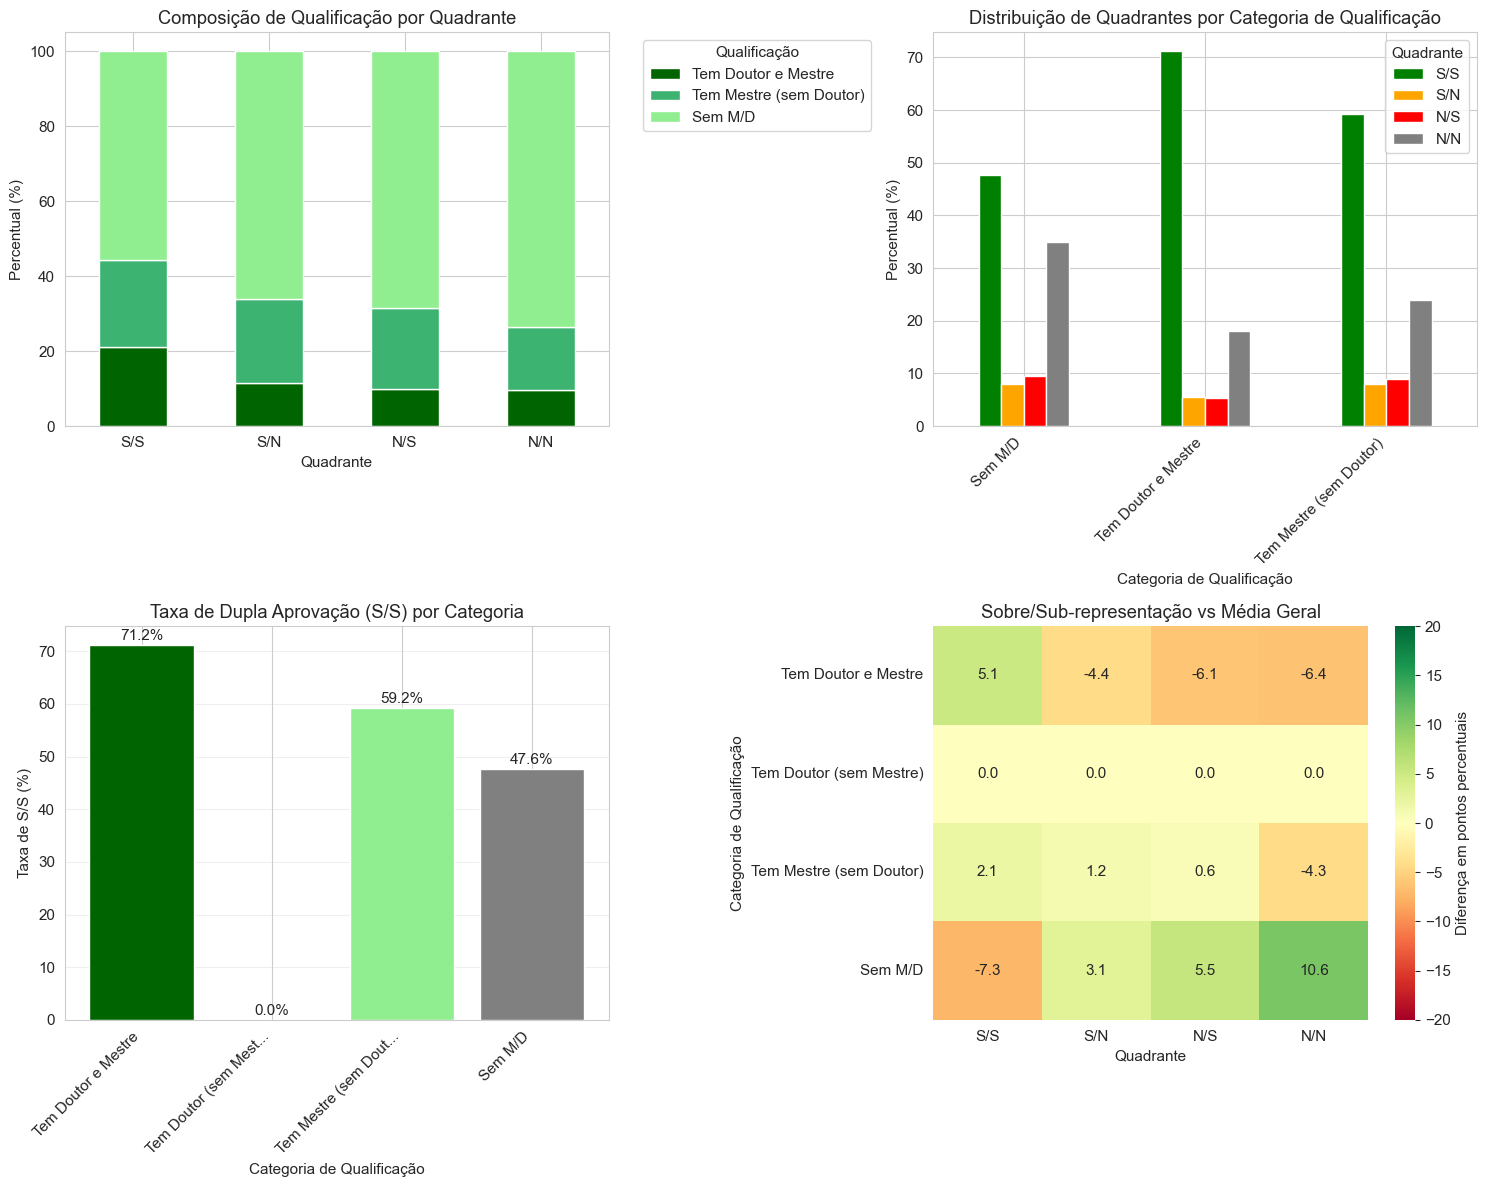


INSIGHTS PRINCIPAIS DA ANÁLISE 3.1
-------------------------------------------------------------------------

Tem Doutor e Mestre:
  Taxa S/S (ambos aprovam): 71.2%
  Taxa aprovação Ministério: 76.6%

Tem Mestre (sem Doutor):
  Taxa S/S (ambos aprovam): 59.2%
  Taxa aprovação Ministério: 68.2%

Sem M/D:
  Taxa S/S (ambos aprovam): 47.6%
  Taxa aprovação Ministério: 57.1%


In [75]:
print(f"\n{'='*73}")
print("ANÁLISE 3.1: IMPORTÂNCIA DE MESTRES E DOUTORES POR QUADRANTE")
print(f"{'='*73}")

# Criar as 4 categorias de qualificação
df_analise['categoria_qualificacao'] = 'Sem M/D'

# Tem Doutor e Mestre
df_analise.loc[(df_analise['tem_doutor'] == 1) & (df_analise['tem_mestre'] == 1), 
               'categoria_qualificacao'] = 'Tem Doutor e Mestre'

# Tem apenas Doutor (sem Mestre)
df_analise.loc[(df_analise['tem_doutor'] == 1) & (df_analise['tem_mestre'] == 0), 
               'categoria_qualificacao'] = 'Tem Doutor (sem Mestre)'

# Tem apenas Mestre (sem Doutor)
df_analise.loc[(df_analise['tem_doutor'] == 0) & (df_analise['tem_mestre'] == 1), 
               'categoria_qualificacao'] = 'Tem Mestre (sem Doutor)'

# Verificar distribuição das categorias
print("Distribuição das categorias de qualificação:")
print(df_analise['categoria_qualificacao'].value_counts())
print(f"\nPercentual:")
print(df_analise['categoria_qualificacao'].value_counts(normalize=True) * 100)

categorias_existentes = ['Tem Doutor e Mestre', 'Tem Doutor (sem Mestre)', 
                        'Tem Mestre (sem Doutor)', 'Sem M/D']

# Análise por quadrante
print("\n" + "="*73)
print("DISTRIBUIÇÃO DE QUALIFICAÇÃO POR QUADRANTE")
print("-"*73)

resultados_qualificacao = {}

for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    print(f"\n{q}:")
    df_q = df_analise[df_analise['quadrante'] == q]
    
    # Distribuição de categorias neste quadrante
    dist = df_q['categoria_qualificacao'].value_counts(normalize=True) * 100
    
    print("  Composição do quadrante:")
    for cat in categorias_existentes:
        if cat in dist.index:
            print(f"    {cat:28}: {dist[cat]:.1f}%")
        else:
            print(f"    {cat:28}: 0.0%")
    
    # Comparar com distribuição geral
    dist_geral = df_analise['categoria_qualificacao'].value_counts(normalize=True) * 100
    
    # Calcular sobre-representação
    print("\n  Sobre/sub-representação (vs média geral):")
    for cat in categorias_existentes:
        if cat in dist.index and cat in dist_geral.index:
            diff = dist[cat] - dist_geral[cat]
            ratio = dist[cat] / dist_geral[cat]
            resultados_qualificacao[f"{q}_{cat}"] = {'diff': diff, 'ratio': ratio}
            
            if diff > 2:
                print(f"    {cat:28}: +{diff:.1f}pp (↑ {ratio:.2f}x)")
            elif diff < -2:
                print(f"    {cat:28}: {diff:.1f}pp (↓ {ratio:.2f}x)")
            else:
                print(f"    {cat:28}: {diff:+.1f}pp (≈ média)")

# Análise inversa: dado uma categoria, qual a probabilidade de cada quadrante
print(f"\n{'='*73}")
print("PROBABILIDADE DE QUADRANTE DADA A QUALIFICAÇÃO")
print("-"*73)

for cat in categorias_existentes:
    df_cat = df_analise[df_analise['categoria_qualificacao'] == cat]
    if len(df_cat) > 0:
        print(f"\n{cat} (n={len(df_cat):,}):")
        dist_quad = df_cat['quadrante'].value_counts(normalize=True) * 100
        
        for q in ['S/S', 'S/N', 'N/S', 'N/N']:
            if q in dist_quad.index:
                # Comparar com média geral
                media_geral = (df_analise['quadrante'] == q).mean() * 100
                diff = dist_quad[q] - media_geral
                
                if abs(diff) > 3:
                    sinal = "↑" if diff > 0 else "↓"
                    print(f"  {q}: {dist_quad[q]:.1f}% ({sinal} {abs(diff):.1f}pp vs média)")
                else:
                    print(f"  {q}: {dist_quad[q]:.1f}% (≈ média)")

# Teste estatístico de independência
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_analise['categoria_qualificacao'], df_analise['quadrante'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n{'='*73}")
print("TESTE DE INDEPENDÊNCIA")
print("-"*73)
print(f"Chi-quadrado: {chi2:.2f}")
print(f"P-value: {p_value:.2e}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.001:
    print("\n✓ Há uma associação MUITO FORTE entre qualificação e quadrantes (p < 0.001)")
elif p_value < 0.05:
    print("\n✓ Há uma associação significativa entre qualificação e quadrantes (p < 0.05)")
else:
    print("\n✗ Não há associação significativa entre qualificação e quadrantes")

# Visualização modificada para 4 categorias
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Distribuição de categorias por quadrante
cat_by_quad = pd.crosstab(df_analise['quadrante'], 
                          df_analise['categoria_qualificacao'], 
                          normalize='index') * 100

cat_by_quad = cat_by_quad.sort_index(ascending=False)

# Ordenar colunas
cols_ordered = ['Tem Doutor e Mestre', 'Tem Doutor (sem Mestre)', 
                'Tem Mestre (sem Doutor)', 'Sem M/D']
cols_to_plot = [col for col in cols_ordered if col in cat_by_quad.columns]

colors = ['darkgreen', 'mediumseagreen', 'lightgreen', 'gray']

cat_by_quad[cols_to_plot].plot(
    kind='bar', stacked=True, ax=axes[0,0], 
    color=colors[:len(cols_to_plot)]
)
axes[0,0].set_title('Composição de Qualificação por Quadrante')
axes[0,0].set_xlabel('Quadrante')
axes[0,0].set_ylabel('Percentual (%)')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=0)
axes[0,0].legend(title='Qualificação', bbox_to_anchor=(1.05, 1))

# Gráfico 2: Probabilidade de quadrante por categoria
quad_by_cat = pd.crosstab(df_analise['categoria_qualificacao'], 
                          df_analise['quadrante'], 
                          normalize='index') * 100

quad_by_cat[['S/S', 'S/N', 'N/S', 'N/N']].plot(
    kind='bar', ax=axes[0,1],
    color=['green', 'orange', 'red', 'gray']
)
axes[0,1].set_title('Distribuição de Quadrantes por Categoria de Qualificação')
axes[0,1].set_xlabel('Categoria de Qualificação')
axes[0,1].set_ylabel('Percentual (%)')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45, ha='right')
axes[0,1].legend(title='Quadrante')

# Gráfico 3: Taxa de aprovação S/S por categoria
taxa_ss = []
for cat in categorias_existentes:
    df_cat = df_analise[df_analise['categoria_qualificacao'] == cat]
    if len(df_cat) > 0:
        taxa = (df_cat['quadrante'] == 'S/S').mean() * 100
        taxa_ss.append(taxa)
    else:
        taxa_ss.append(0)

axes[1,0].bar(range(len(categorias_existentes)), taxa_ss, 
              color=['darkgreen', 'mediumseagreen', 'lightgreen', 'gray'])
axes[1,0].set_xlabel('Categoria de Qualificação')
axes[1,0].set_ylabel('Taxa de S/S (%)')
axes[1,0].set_title('Taxa de Dupla Aprovação (S/S) por Categoria')
axes[1,0].set_xticks(range(len(categorias_existentes)))
axes[1,0].set_xticklabels([cat[:20] + '...' if len(cat) > 20 else cat 
                           for cat in categorias_existentes], rotation=45, ha='right')
axes[1,0].grid(True, alpha=0.3, axis='y')

# Adicionar valores no topo das barras
for i, val in enumerate(taxa_ss):
    axes[1,0].text(i, val + 1, f'{val:.1f}%', ha='center')

# Gráfico 4: Heatmap de sobre-representação
matriz_sobre = pd.DataFrame(index=categorias_existentes,
                           columns=['S/S', 'S/N', 'N/S', 'N/N'])

for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    for cat in categorias_existentes:
        key = f"{q}_{cat}"
        if key in resultados_qualificacao:
            matriz_sobre.loc[cat, q] = resultados_qualificacao[key]['diff']

matriz_sobre = matriz_sobre.astype(float).fillna(0)
sns.heatmap(matriz_sobre, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=axes[1,1],
            cbar_kws={'label': 'Diferença em pontos percentuais'},
            vmin=-20, vmax=20)
axes[1,1].set_title('Sobre/Sub-representação vs Média Geral')
axes[1,1].set_xlabel('Quadrante')
axes[1,1].set_ylabel('Categoria de Qualificação')

plt.tight_layout()
plt.show()

# Insights principais
print(f"\n{'='*73}")
print("INSIGHTS PRINCIPAIS DA ANÁLISE 3.1")
print("-"*73)

# Taxa de sucesso por categoria
for cat in categorias_existentes:
    df_cat = df_analise[df_analise['categoria_qualificacao'] == cat]
    if len(df_cat) > 0:
        taxa_ss = (df_cat['quadrante'] == 'S/S').mean() * 100
        taxa_aprovacao_min = df_cat['ministerio_aprova'].mean() * 100
        print(f"\n{cat}:")
        print(f"  Taxa S/S (ambos aprovam): {taxa_ss:.1f}%")
        print(f"  Taxa aprovação Ministério: {taxa_aprovacao_min:.1f}%")

### 5.2. Análise 3.2: Mestres e Doutores por Quadrante e Setor

Esta análise reconhece que diferentes setores tecnológicos podem ter dinâmicas distintas quanto à importância da qualificação. Para cada setor, calcula-se a correlação de Spearman entre quantidade de doutores/mestres e taxa de aprovação.

A **correlação de Spearman** é usada por ser robusta a outliers e não assumir relação linear. Valores positivos indicam que mais qualificação aumenta aprovação, negativos indicam o contrário. O caso do TIC é particularmente interessante, mostrando correlação negativa - possivelmente porque projetos muito acadêmicos são vistos como menos práticos neste setor. A análise por **faixas de quantidade** (0, 1, 2-3, 4+) complementa mostrando como a taxa de aprovação varia em diferentes níveis de qualificação.


ANÁLISE 3.2: MESTRES E DOUTORES POR QUADRANTE E SETOR

QUANTIDADE MÉDIA DE DOUTORES E MESTRES POR QUADRANTE E SETOR

Agroindústria e Alimentos (n=8,140)
----------------------------------------
  S/S: Dout=3.6, Mest=5.1 (4235 proj, 52.0%)
  S/N: Dout=2.5, Mest=4.2 (694 proj, 8.5%)
  N/S: Dout=1.9, Mest=2.1 (614 proj, 7.5%)
  N/N: Dout=2.0, Mest=3.1 (2597 proj, 31.9%)

Eletroeletrônica (n=6,851)
----------------------------------------
  S/S: Dout=1.4, Mest=2.7 (3927 proj, 57.3%)
  S/N: Dout=1.3, Mest=2.7 (157 proj, 2.3%)
  N/S: Dout=1.3, Mest=3.4 (792 proj, 11.6%)
  N/N: Dout=1.2, Mest=2.4 (1975 proj, 28.8%)

Mecânica e Transporte (n=9,061)
----------------------------------------
  S/S: Dout=1.9, Mest=4.5 (4950 proj, 54.6%)
  S/N: Dout=1.2, Mest=1.4 (404 proj, 4.5%)
  N/S: Dout=1.2, Mest=2.8 (1230 proj, 13.6%)
  N/N: Dout=1.8, Mest=2.8 (2477 proj, 27.3%)

Metalurgia e Mineração (n=4,989)
----------------------------------------
  S/S: Dout=1.6, Mest=2.3 (2858 proj, 57.3%)
  S/N: Dout

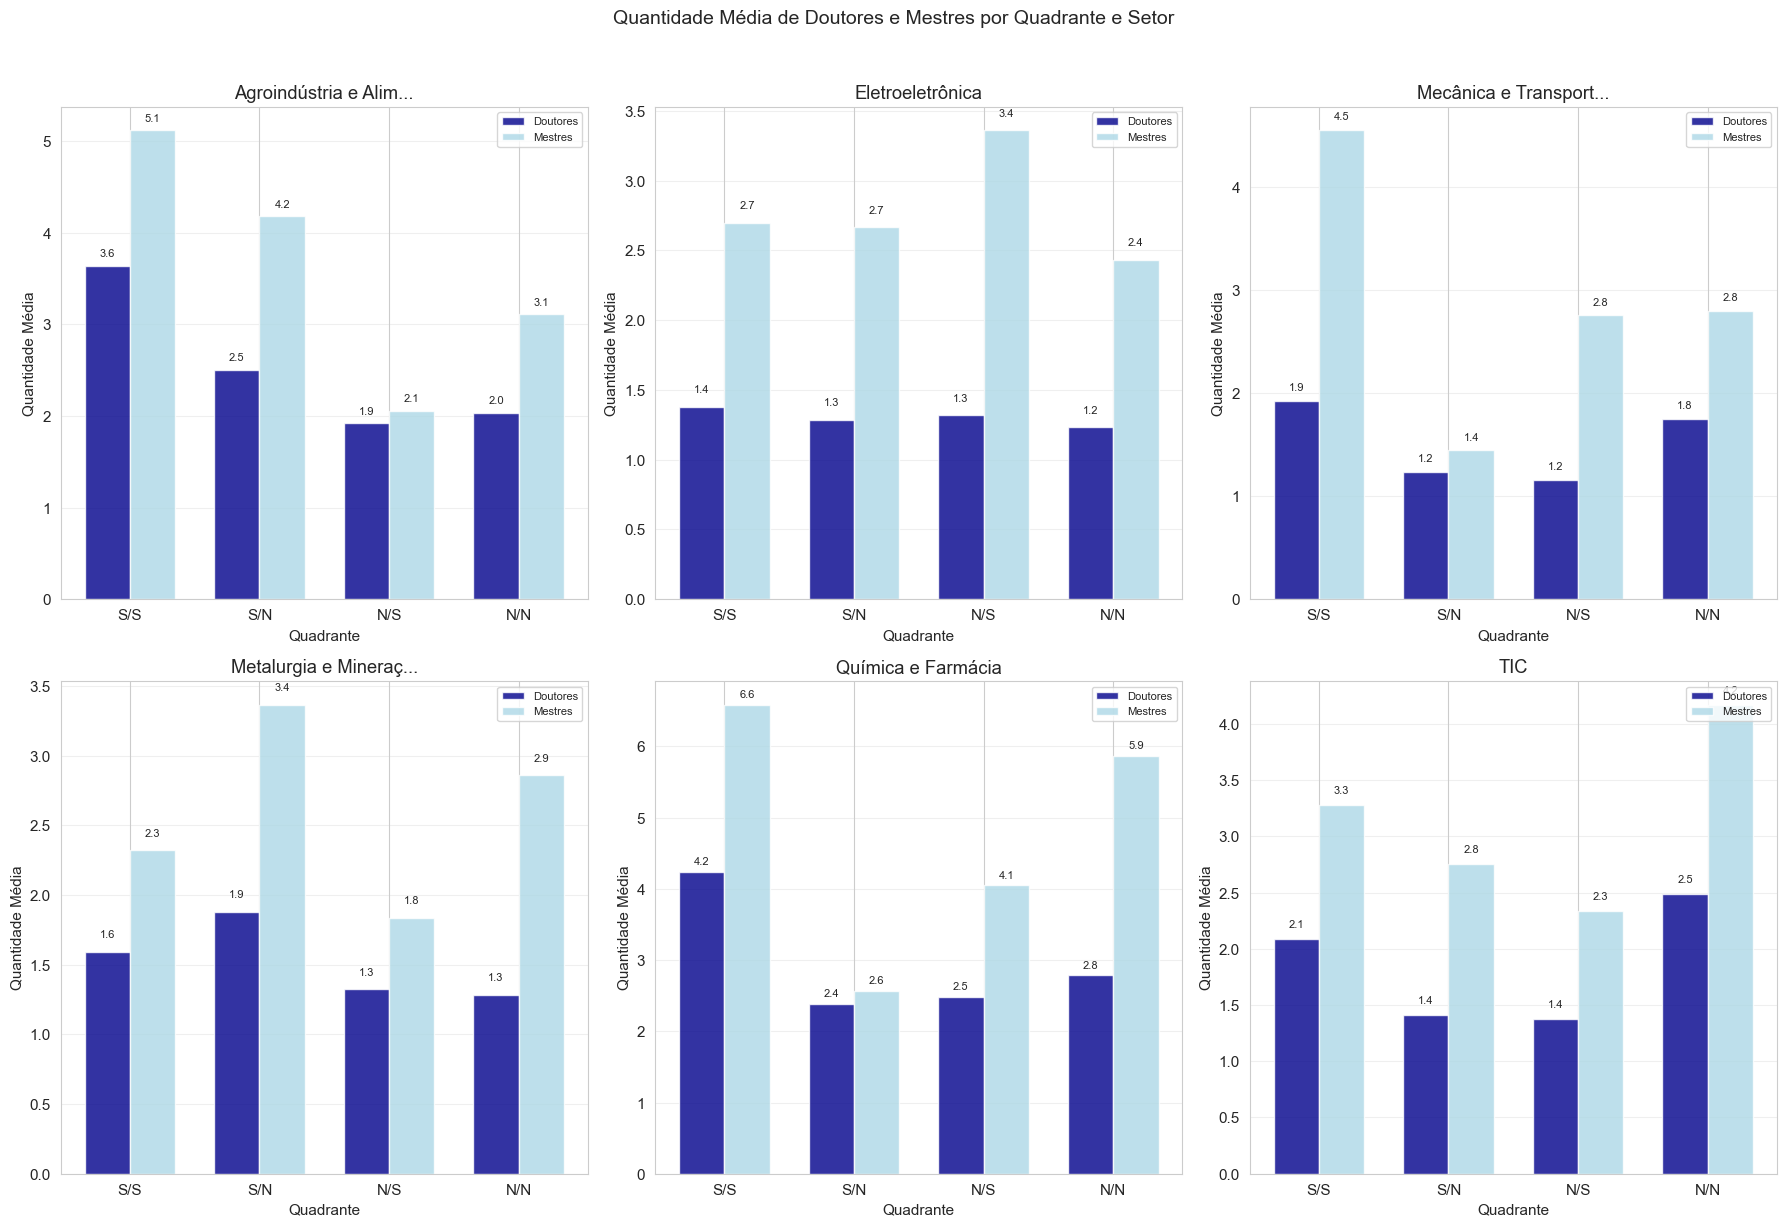

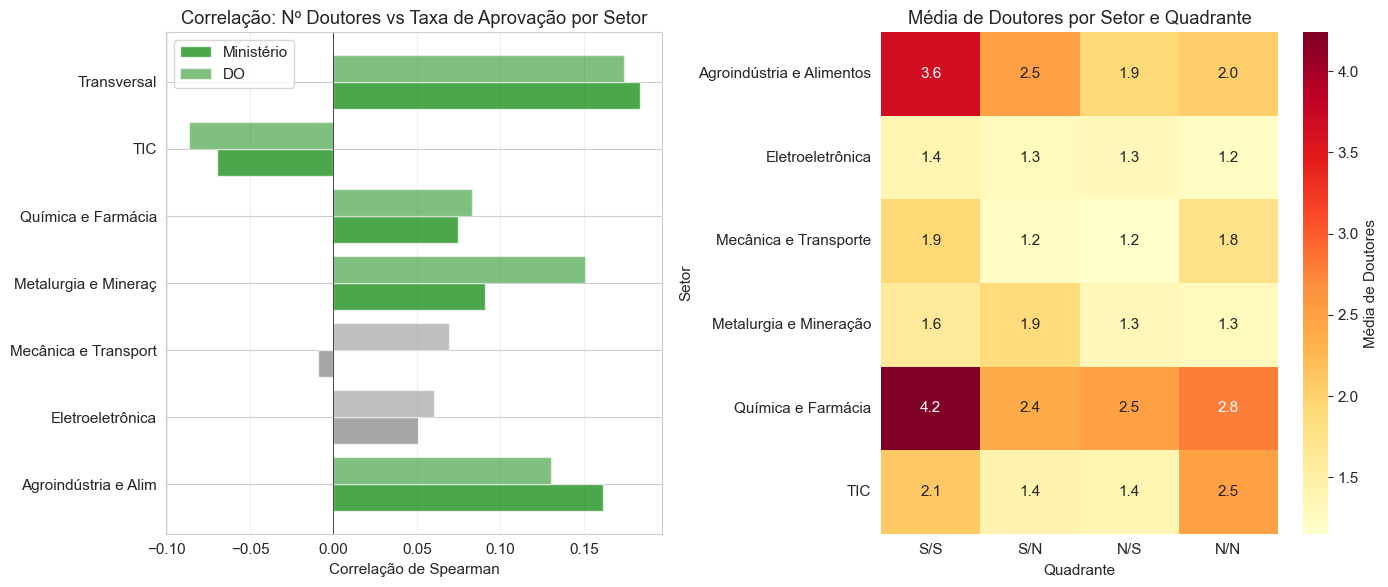


PRINCIPAIS INSIGHTS DA ANÁLISE 3.2

2. CORRELAÇÕES SIGNIFICATIVAS (p < 0.05):
   Agroindústria e Alimentos: r=0.162 (Ministério)
   Metalurgia e Mineração: r=0.091 (Ministério)
   Química e Farmácia: r=0.075 (Ministério)
   TIC: r=-0.070 (Ministério)
   Transversal: r=0.184 (Ministério)

3. PADRÕES OBSERVADOS:
   Média geral de doutores em Q1: nan
   Média geral de doutores em Q4: nan
   Diferença: nan doutores


In [68]:
print(f"\n{'='*73}")
print("ANÁLISE 3.2: MESTRES E DOUTORES POR QUADRANTE E SETOR")
print(f"{'='*73}")

# Setores para análise
setores = ['Agroindústria e Alimentos', 'Eletroeletrônica', 'Mecânica e Transporte', 
           'Metalurgia e Mineração', 'Química e Farmácia', 'TIC', 'Transversal']

# Estrutura para armazenar resultados
resultados_setor_quad = {}

print("\nQUANTIDADE MÉDIA DE DOUTORES E MESTRES POR QUADRANTE E SETOR")
print("="*73)

for setor in setores:
    df_setor = df_analise[df_analise['setor'] == setor]
    
    if len(df_setor) < 30:  # Skip setores com poucos dados
        continue
    
    print(f"\n{setor} (n={len(df_setor):,})")
    print("-"*40)
    
    resultados_setor_quad[setor] = {}
    
    # Análise por quadrante
    for q in ['S/S', 'S/N', 'N/S', 'N/N']:
        df_sq = df_setor[df_setor['quadrante'] == q]
        
        if len(df_sq) > 0:
            media_dout = df_sq['quantdoutorproj'].mean()
            media_mest = df_sq['quantmestreproj'].mean()
            n_proj = len(df_sq)
            pct_proj = (n_proj / len(df_setor)) * 100
            
            resultados_setor_quad[setor][q] = {
                'media_doutores': media_dout,
                'media_mestres': media_mest,
                'n_projetos': n_proj,
                'pct_projetos': pct_proj
            }
            
            print(f"  {q}: Dout={media_dout:.1f}, Mest={media_mest:.1f} ({n_proj} proj, {pct_proj:.1f}%)")

print(f"\n{'='*73}")
print("CORRELAÇÃO: QUANTIDADE DE DOUTORES VS TAXA DE APROVAÇÃO POR SETOR")
print("="*73)

correlacoes_setor = {}

for setor in setores:
    df_setor = df_analise[df_analise['setor'] == setor]
    
    if len(df_setor) < 30:
        continue
    
    print(f"\n{setor}:")
    print("-"*30)
    
    # Usar valores ORIGINAIS, não categorizados
    # Remover NaN antes de calcular correlação
    df_valid = df_setor.dropna(subset=['quantdoutorproj', 'ministerio_aprova', 'pesquisador_aprova'])
    
    if len(df_valid) > 10 and df_valid['quantdoutorproj'].var() > 0:
        # Correlação com valores contínuos
        corr_min, p_value_min = stats.spearmanr(df_valid['quantdoutorproj'], 
                                                 df_valid['ministerio_aprova'])
        corr_do, p_value_do = stats.spearmanr(df_valid['quantdoutorproj'], 
                                              df_valid['pesquisador_aprova'])
        
        correlacoes_setor[setor] = {
            'corr_ministerio': corr_min,
            'p_value_ministerio': p_value_min,
            'corr_do': corr_do,
            'p_value_do': p_value_do
        }
        
        print(f"  Correlação Spearman:")
        print(f"    Ministério: r={corr_min:.3f}, p={p_value_min:.4f}")
        print(f"    DO:         r={corr_do:.3f}, p={p_value_do:.4f}")
        
        # Interpretação
        if p_value_min < 0.05:
            if corr_min > 0:
                print(f"    → Mais doutores AUMENTA aprovação Ministério")
            else:
                print(f"    → Mais doutores DIMINUI aprovação Ministério")
    else:
        print(f"  Dados insuficientes ou sem variação")
    
    # Análise por faixas (complementar)
    df_setor_copy = df_setor.copy()
    df_setor_copy['faixa_doutores'] = pd.cut(df_setor_copy['quantdoutorproj'], 
                                              bins=[-0.1, 0, 1, 3, 100], 
                                              labels=['0', '1', '2-3', '4+'])
    
    print(f"\n  Taxa de aprovação por faixa:")
    for faixa in ['0', '1', '2-3', '4+']:
        df_faixa = df_setor_copy[df_setor_copy['faixa_doutores'] == faixa]
        if len(df_faixa) > 0:
            taxa_min = df_faixa['ministerio_aprova'].mean() * 100
            taxa_do = df_faixa['pesquisador_aprova'].mean() * 100
            n = len(df_faixa)
            print(f"    {faixa:4} doutores (n={n:4}): Min={taxa_min:.1f}%, DO={taxa_do:.1f}%")

# Visualizações
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Preparar dados para visualização
setores_plot = [s for s in setores if s in resultados_setor_quad][:6]  # Top 6 setores

# Gráfico 1-6: Um para cada setor mostrando médias por quadrante
for i, setor in enumerate(setores_plot):
    if i >= 6:
        break
        
    # Preparar dados do setor
    quadrantes = ['S/S', 'S/N', 'N/S', 'N/N']
    medias_dout = []
    medias_mest = []
    
    for q in quadrantes:
        if q in resultados_setor_quad[setor]:
            medias_dout.append(resultados_setor_quad[setor][q]['media_doutores'])
            medias_mest.append(resultados_setor_quad[setor][q]['media_mestres'])
        else:
            medias_dout.append(0)
            medias_mest.append(0)
    
    x = np.arange(len(quadrantes))
    width = 0.35
    
    axes[i].bar(x - width/2, medias_dout, width, label='Doutores', color='darkblue', alpha=0.8)
    axes[i].bar(x + width/2, medias_mest, width, label='Mestres', color='lightblue', alpha=0.8)
    
    axes[i].set_xlabel('Quadrante')
    axes[i].set_ylabel('Quantidade Média')
    axes[i].set_title(f'{setor[:20]}...' if len(setor) > 20 else setor)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(quadrantes)
    axes[i].legend(loc='upper right', fontsize=8)
    axes[i].grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores no topo das barras
    for j, (d, m) in enumerate(zip(medias_dout, medias_mest)):
        if d > 0:
            axes[i].text(j - width/2, d + 0.1, f'{d:.1f}', ha='center', fontsize=8)
        if m > 0:
            axes[i].text(j + width/2, m + 0.1, f'{m:.1f}', ha='center', fontsize=8)

plt.suptitle('Quantidade Média de Doutores e Mestres por Quadrante e Setor', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Segunda visualização: Correlação por setor
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Preparar dados de correlação
setores_corr = list(correlacoes_setor.keys())
corr_ministerio = [correlacoes_setor[s]['corr_ministerio'] for s in setores_corr]
corr_do = [correlacoes_setor[s]['corr_do'] for s in setores_corr]
p_val_ministerio = [correlacoes_setor[s]['p_value_ministerio'] for s in setores_corr]
p_val_do = [correlacoes_setor[s]['p_value_do'] for s in setores_corr]

# Gráfico 1: Correlações
y_pos = np.arange(len(setores_corr))
colors_min = ['green' if p < 0.05 else 'gray' for p in p_val_ministerio]
colors_do = ['green' if p < 0.05 else 'gray' for p in p_val_do]

axes[0].barh(y_pos - 0.2, corr_ministerio, 0.4, label='Ministério', color=colors_min, alpha=0.7)
axes[0].barh(y_pos + 0.2, corr_do, 0.4, label='DO', color=colors_do, alpha=0.5)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels([s[:20] for s in setores_corr])
axes[0].set_xlabel('Correlação de Spearman')
axes[0].set_title('Correlação: Nº Doutores vs Taxa de Aprovação por Setor')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Gráfico 2: Heatmap de média de doutores por setor e quadrante
matriz_doutores = pd.DataFrame(index=setores_plot, columns=['S/S', 'S/N', 'N/S', 'N/N'])

for setor in setores_plot:
    for q in ['S/S', 'S/N', 'N/S', 'N/N']:
        if q in resultados_setor_quad[setor]:
            matriz_doutores.loc[setor, q] = resultados_setor_quad[setor][q]['media_doutores']

matriz_doutores = matriz_doutores.astype(float).fillna(0)
sns.heatmap(matriz_doutores, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1],
            cbar_kws={'label': 'Média de Doutores'})
axes[1].set_title('Média de Doutores por Setor e Quadrante')
axes[1].set_xlabel('Quadrante')
axes[1].set_ylabel('Setor')

plt.tight_layout()
plt.show()

# Resumo dos insights
print(f"\n{'='*73}")
print("PRINCIPAIS INSIGHTS DA ANÁLISE 3.2")
print("="*73)

# Setor com maior diferença entre Q1 e Q4
max_diff_setor = None
max_diff_value = 0

for setor in resultados_setor_quad:
    if 'Q1' in resultados_setor_quad[setor] and 'Q4' in resultados_setor_quad[setor]:
        diff = resultados_setor_quad[setor]['Q1']['media_doutores'] - resultados_setor_quad[setor]['Q4']['media_doutores']
        if diff > max_diff_value:
            max_diff_value = diff
            max_diff_setor = setor

if max_diff_setor:
    print(f"\n1. MAIOR DIFERENÇA Q1 vs Q4:")
    print(f"   Setor: {max_diff_setor}")
    print(f"   Diferença: {max_diff_value:.1f} doutores a mais em Q1")

# Correlações significativas
print(f"\n2. CORRELAÇÕES SIGNIFICATIVAS (p < 0.05):")
for setor in correlacoes_setor:
    if correlacoes_setor[setor]['p_value_ministerio'] < 0.05:
        print(f"   {setor}: r={correlacoes_setor[setor]['corr_ministerio']:.3f} (Ministério)")

# Padrões gerais
print(f"\n3. PADRÕES OBSERVADOS:")
q1_avg_dout = np.mean([resultados_setor_quad[s]['Q1']['media_doutores'] 
                       for s in resultados_setor_quad if 'Q1' in resultados_setor_quad[s]])
q4_avg_dout = np.mean([resultados_setor_quad[s]['Q4']['media_doutores'] 
                       for s in resultados_setor_quad if 'Q4' in resultados_setor_quad[s]])

print(f"   Média geral de doutores em Q1: {q1_avg_dout:.1f}")
print(f"   Média geral de doutores em Q4: {q4_avg_dout:.1f}")
print(f"   Diferença: {q1_avg_dout - q4_avg_dout:.1f} doutores")

## 6. Análise 4: Percentual de Gastos (RH e Terceiros) por Setor

Esta análise investiga se a composição dos gastos do projeto - especificamente a proporção destinada a recursos humanos internos versus serviços terceirizados - afeta as chances de aprovação, reconhecendo que essa relação pode variar entre setores.

A regressão logística captura como cada ponto percentual adicional gasto em RH ou terceirização afeta a probabilidade de aprovação. Os resultados revelam padrões setoriais distintos: em Química e Farmácia, maior terceirização aumenta aprovação (talvez indicando colaboração com laboratórios especializados), enquanto em TIC o efeito é oposto (possivelmente valorizando desenvolvimento interno).


ANÁLISE 4: PERCENTUAL DE GASTOS COM RH E TERCEIROS POR SETOR

SETOR: Agroindústria e Alimentos (n=8140)

GASTOS COM RH:
------------------------------

  Ministério:
    Coeficiente: 0.3827
    Correlação: 0.1446
    P-value: 0.0000
    ✓ Maior % RH AUMENTA aprovação

  DO:
    Coeficiente: 0.2258
    Correlação: 0.0442
    P-value: 0.0001
    ✓ Maior % RH AUMENTA aprovação

GASTOS COM TERCEIROS:
------------------------------

  Ministério:
    Coeficiente: 0.0763
    Correlação: 0.1281
    P-value: 0.0000
    ✓ Maior % Terceiros AUMENTA aprovação

  DO:
    Coeficiente: 0.2932
    Correlação: 0.2542
    P-value: 0.0000
    ✓ Maior % Terceiros AUMENTA aprovação

SETOR: Eletroeletrônica (n=6851)

GASTOS COM RH:
------------------------------

  Ministério:
    Coeficiente: -0.0789
    Correlação: -0.0296
    P-value: 0.0141
    ✓ Maior % RH DIMINUI aprovação

  DO:
    Coeficiente: -0.1425
    Correlação: -0.0642
    P-value: 0.0000
    ✓ Maior % RH DIMINUI aprovação

GASTOS COM TERCE

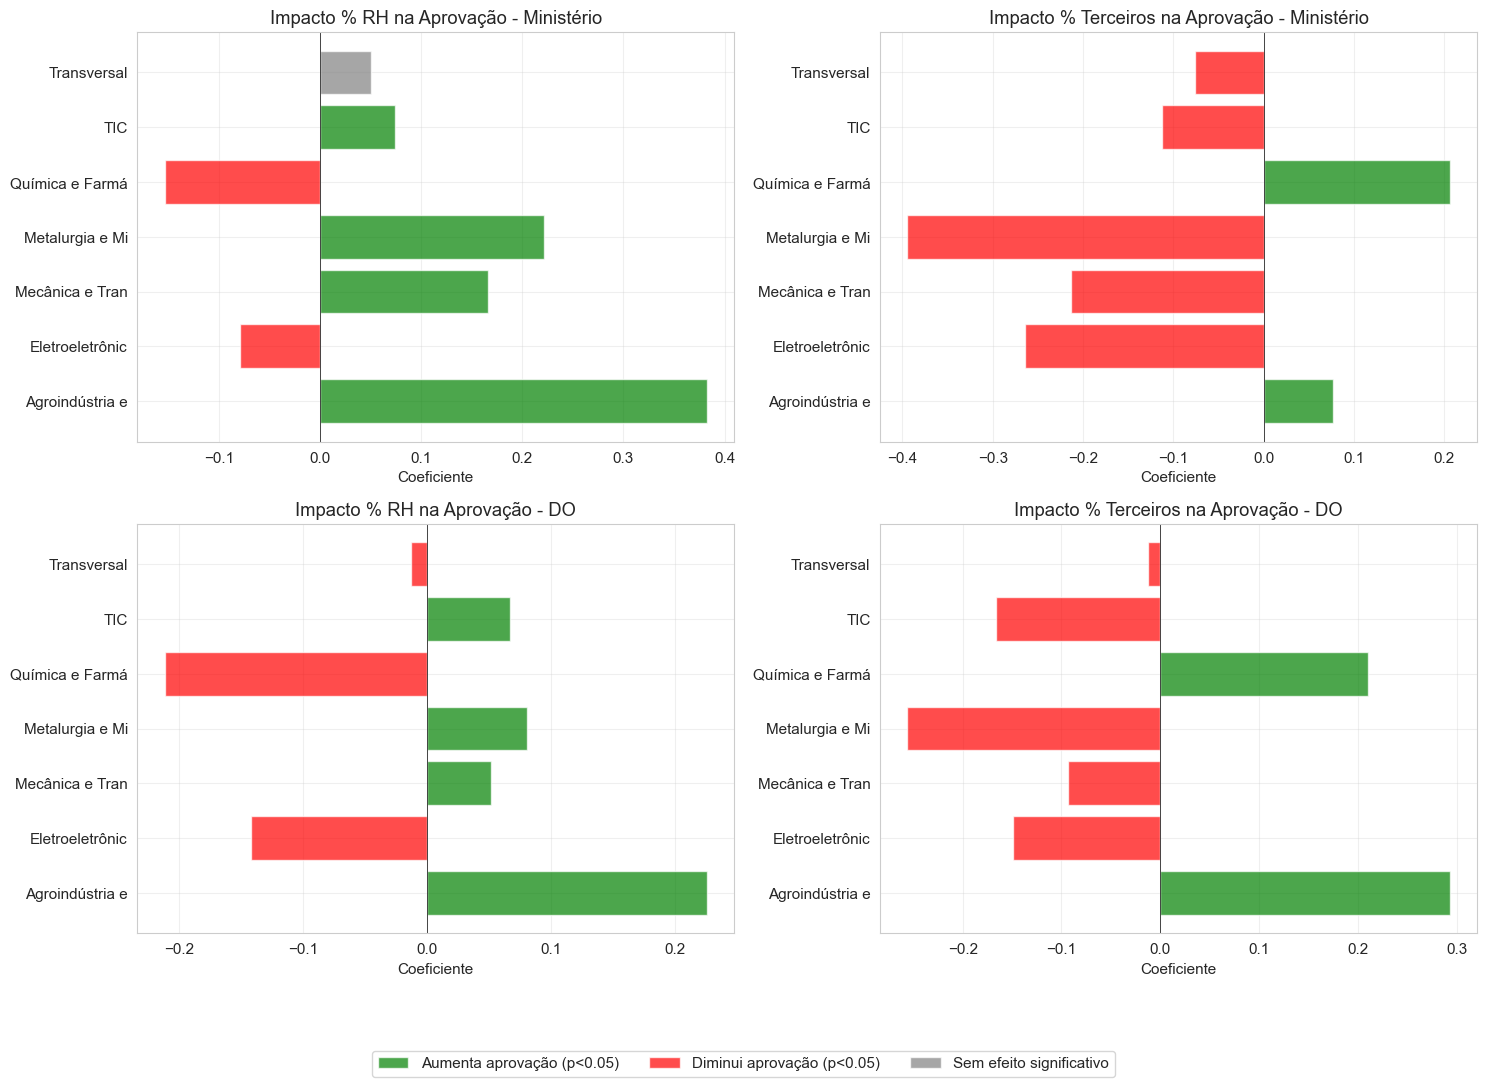

In [61]:
print(f"\n{'='*73}")
print("ANÁLISE 4: PERCENTUAL DE GASTOS COM RH E TERCEIROS POR SETOR")
print(f"{'='*73}")

# Calcular percentual de gastos
df_analise['perc_gasto_rh'] = (df_analise['valorrhproj'] / df_analise['valortotalproj'].replace(0, np.nan)) * 100
df_analise['perc_gasto_terceiros'] = df_analise['percservterceirosproj'] * 100

# Setores para análise
setores = ['Agroindústria e Alimentos', 'Eletroeletrônica', 'Mecânica e Transporte', 
           'Metalurgia e Mineração', 'Química e Farmácia', 'TIC', 'Transversal']

resultados_setor = {}

for setor in setores:
    df_setor = df_analise[df_analise['setor'] == setor].copy()
    
    if len(df_setor) < 30:  # Skip se poucos dados
        continue
        
    print(f"\n{'='*60}")
    print(f"SETOR: {setor} (n={len(df_setor)})")
    print(f"{'='*60}")
    
    resultados_setor[setor] = {}
    
    # Análise para RH
    print("\nGASTOS COM RH:")
    print("-"*30)
    
    for aprovador, coluna in [('Ministério', 'ministerio_aprova'), ('DO', 'pesquisador_aprova')]:
        # Regressão logística
        X_rh = df_setor[['perc_gasto_rh']].fillna(0)
        y = df_setor[coluna]
        
        if len(np.unique(y)) > 1:  # Verificar se há variação
            model = LogisticRegression(random_state=42, max_iter=1000)
            model.fit(StandardScaler().fit_transform(X_rh), y)
            coef = model.coef_[0][0]
            
            # Correlação simples
            corr, p_value = stats.spearmanr(df_setor['perc_gasto_rh'].fillna(0), y)
            
            resultados_setor[setor][f'rh_{aprovador}'] = {
                'coef': coef,
                'corr': corr,
                'p_value': p_value
            }
            
            print(f"\n  {aprovador}:")
            print(f"    Coeficiente: {coef:.4f}")
            print(f"    Correlação: {corr:.4f}")
            print(f"    P-value: {p_value:.4f}")
            
            if p_value < 0.05:
                if coef > 0:
                    print(f"    ✓ Maior % RH AUMENTA aprovação")
                else:
                    print(f"    ✓ Maior % RH DIMINUI aprovação")
            else:
                print(f"    ✗ Sem efeito significativo")
    
    # Análise para Terceiros
    print("\nGASTOS COM TERCEIROS:")
    print("-"*30)
    
    for aprovador, coluna in [('Ministério', 'ministerio_aprova'), ('DO', 'pesquisador_aprova')]:
        # Regressão logística
        X_terc = df_setor[['perc_gasto_terceiros']].fillna(0)
        y = df_setor[coluna]
        
        if len(np.unique(y)) > 1:
            model = LogisticRegression(random_state=42, max_iter=1000)
            model.fit(StandardScaler().fit_transform(X_terc), y)
            coef = model.coef_[0][0]
            
            # Correlação simples
            corr, p_value = stats.spearmanr(df_setor['perc_gasto_terceiros'].fillna(0), y)
            
            resultados_setor[setor][f'terceiros_{aprovador}'] = {
                'coef': coef,
                'corr': corr,
                'p_value': p_value
            }
            
            print(f"\n  {aprovador}:")
            print(f"    Coeficiente: {coef:.4f}")
            print(f"    Correlação: {corr:.4f}")
            print(f"    P-value: {p_value:.4f}")
            
            if p_value < 0.05:
                if coef > 0:
                    print(f"    ✓ Maior % Terceiros AUMENTA aprovação")
                else:
                    print(f"    ✓ Maior % Terceiros DIMINUI aprovação")
            else:
                print(f"    ✗ Sem efeito significativo")

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Preparar dados para visualização
setores_plot = [s for s in setores if s in resultados_setor]

# Gráfico 1: Coeficientes RH - Ministério
coefs_rh_min = [resultados_setor[s].get('rh_Ministério', {}).get('coef', 0) for s in setores_plot]
p_vals_rh_min = [resultados_setor[s].get('rh_Ministério', {}).get('p_value', 1) for s in setores_plot]
colors_rh_min = ['green' if p < 0.05 and c > 0 else 'red' if p < 0.05 and c < 0 else 'gray' 
                 for c, p in zip(coefs_rh_min, p_vals_rh_min)]

axes[0,0].barh(range(len(setores_plot)), coefs_rh_min, color=colors_rh_min, alpha=0.7)
axes[0,0].set_yticks(range(len(setores_plot)))
axes[0,0].set_yticklabels([s[:15] for s in setores_plot])
axes[0,0].set_xlabel('Coeficiente')
axes[0,0].set_title('Impacto % RH na Aprovação - Ministério')
axes[0,0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Coeficientes Terceiros - Ministério
coefs_terc_min = [resultados_setor[s].get('terceiros_Ministério', {}).get('coef', 0) for s in setores_plot]
p_vals_terc_min = [resultados_setor[s].get('terceiros_Ministério', {}).get('p_value', 1) for s in setores_plot]
colors_terc_min = ['green' if p < 0.05 and c > 0 else 'red' if p < 0.05 and c < 0 else 'gray' 
                   for c, p in zip(coefs_terc_min, p_vals_terc_min)]

axes[0,1].barh(range(len(setores_plot)), coefs_terc_min, color=colors_terc_min, alpha=0.7)
axes[0,1].set_yticks(range(len(setores_plot)))
axes[0,1].set_yticklabels([s[:15] for s in setores_plot])
axes[0,1].set_xlabel('Coeficiente')
axes[0,1].set_title('Impacto % Terceiros na Aprovação - Ministério')
axes[0,1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Coeficientes RH - DO
coefs_rh_do = [resultados_setor[s].get('rh_DO', {}).get('coef', 0) for s in setores_plot]
p_vals_rh_do = [resultados_setor[s].get('rh_DO', {}).get('p_value', 1) for s in setores_plot]
colors_rh_do = ['green' if p < 0.05 and c > 0 else 'red' if p < 0.05 and c < 0 else 'gray' 
                for c, p in zip(coefs_rh_do, p_vals_rh_do)]

axes[1,0].barh(range(len(setores_plot)), coefs_rh_do, color=colors_rh_do, alpha=0.7)
axes[1,0].set_yticks(range(len(setores_plot)))
axes[1,0].set_yticklabels([s[:15] for s in setores_plot])
axes[1,0].set_xlabel('Coeficiente')
axes[1,0].set_title('Impacto % RH na Aprovação - DO')
axes[1,0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1,0].grid(True, alpha=0.3)

# Gráfico 4: Coeficientes Terceiros - DO
coefs_terc_do = [resultados_setor[s].get('terceiros_DO', {}).get('coef', 0) for s in setores_plot]
p_vals_terc_do = [resultados_setor[s].get('terceiros_DO', {}).get('p_value', 1) for s in setores_plot]
colors_terc_do = ['green' if p < 0.05 and c > 0 else 'red' if p < 0.05 and c < 0 else 'gray' 
                  for c, p in zip(coefs_terc_do, p_vals_terc_do)]

axes[1,1].barh(range(len(setores_plot)), coefs_terc_do, color=colors_terc_do, alpha=0.7)
axes[1,1].set_yticks(range(len(setores_plot)))
axes[1,1].set_yticklabels([s[:15] for s in setores_plot])
axes[1,1].set_xlabel('Coeficiente')
axes[1,1].set_title('Impacto % Terceiros na Aprovação - DO')
axes[1,1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1,1].grid(True, alpha=0.3)

# Adicionar legenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Aumenta aprovação (p<0.05)'),
                  Patch(facecolor='red', alpha=0.7, label='Diminui aprovação (p<0.05)'),
                  Patch(facecolor='gray', alpha=0.7, label='Sem efeito significativo')]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

## Análise 4.1: Percentual de Qualificação (M+D) no Total de RH

Esta análise final examina não apenas a quantidade absoluta de mestres e doutores, mas sua proporção em relação ao total de recursos humanos do projeto. Um projeto pode ter muitos doutores mas ainda assim ter baixo percentual de qualificação se a equipe total for muito grande.

A análise por **faixas de qualificação** (<10%, 10-25%, 25-50%, >50%) mostra de forma clara como projetos com diferentes níveis de "densidade de qualificação" se distribuem entre os quadrantes, revelando que existe um ponto ótimo - projetos com 25-50% de qualificados têm a maior taxa de dupla aprovação (S/S).


ANÁLISE 4.1: PERCENTUAL DE QUALIFICAÇÃO (M+D) NO TOTAL DE RH

ESTATÍSTICAS DESCRITIVAS
------------------------------------------------------------
Percentual médio de qualificação: 37.4%
Mediana: 27.3%
Desvio padrão: 31.1%
Mínimo: 0.2%
Máximo: 100.0%

PERCENTUAL DE QUALIFICAÇÃO POR QUADRANTE
------------------------------------------------------------

S/S:
  Média: 39.7%
  Mediana: 29.4%
  Desvio padrão: 30.9%
  % projetos com >50% qualificados: 5.8%

S/N:
  Média: 27.6%
  Mediana: 20.0%
  Desvio padrão: 27.3%
  % projetos com >50% qualificados: 1.9%

N/S:
  Média: 35.5%
  Mediana: 23.3%
  Desvio padrão: 30.5%
  % projetos com >50% qualificados: 2.3%

N/N:
  Média: 31.9%
  Mediana: 17.6%
  Desvio padrão: 32.0%
  % projetos com >50% qualificados: 2.2%

IMPORTÂNCIA DO PERCENTUAL DE QUALIFICAÇÃO
------------------------------------------------------------

Regressão Logística - Impacto na probabilidade de cada quadrante:

S/S:
  Coeficiente: 0.338
  Odds Ratio: 1.402
  → Alto % qualifi

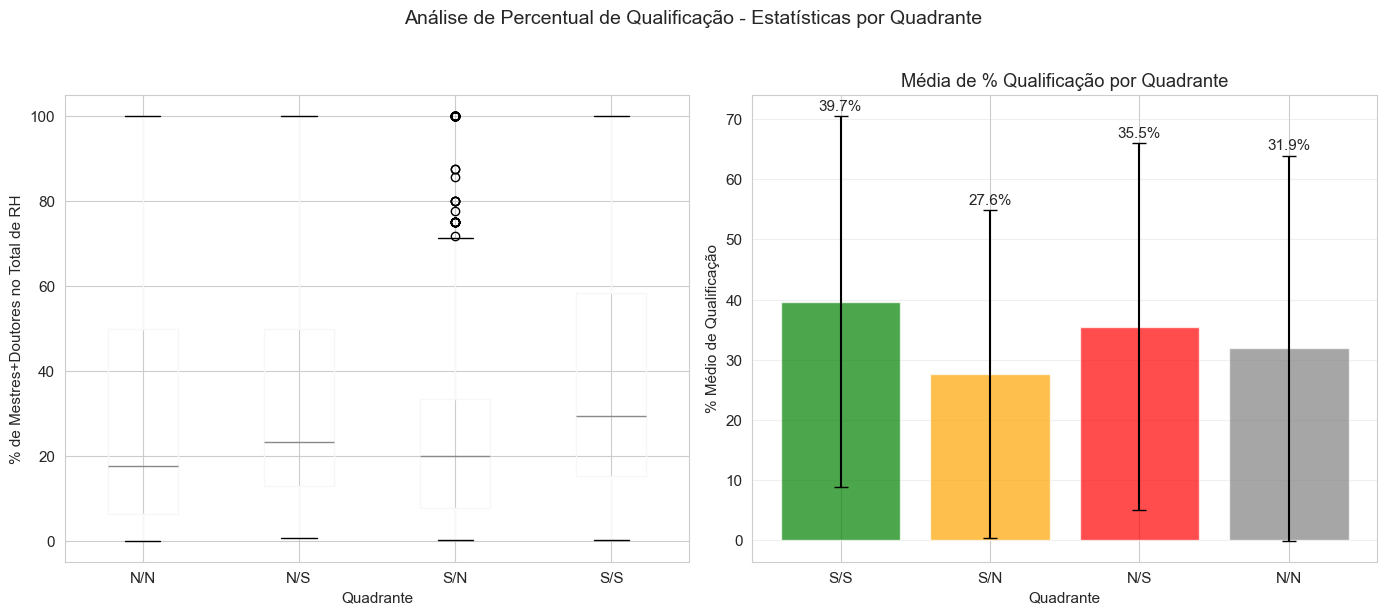

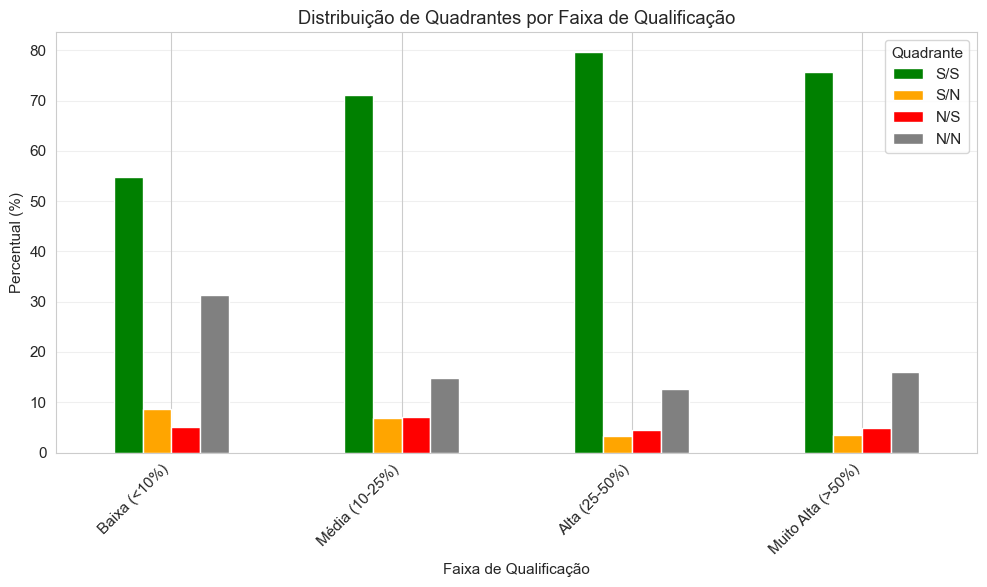


PRINCIPAIS INSIGHTS
------------------------------------------------------------

1. DIFERENÇA S/S vs N/N:
   Média S/S: 39.7%
   Média N/N: 31.9%
   Diferença: +7.8 pontos percentuais

2. QUADRANTE COM MAIOR % DE QUALIFICAÇÃO: S/S

3. CORRELAÇÃO COM APROVAÇÃO:
   Ministério: 0.116
   DO: 0.083


In [74]:
print(f"\n{'='*73}")
print("ANÁLISE 4.1: PERCENTUAL DE QUALIFICAÇÃO (M+D) NO TOTAL DE RH")
print(f"{'='*73}")

# Criar variável de percentual de qualificação
df_analise['total_qualificados'] = df_analise['quantmestreproj'] + df_analise['quantdoutorproj']
df_analise['perc_qualificacao'] = (df_analise['total_qualificados'] / df_analise['quantrhproj'].replace(0, np.nan)) * 100
df_analise['perc_qualificacao'] = df_analise['perc_qualificacao'].clip(upper=100)

# Estatísticas descritivas
print("\nESTATÍSTICAS DESCRITIVAS")
print("-"*60)
print(f"Percentual médio de qualificação: {df_analise['perc_qualificacao'].mean():.1f}%")
print(f"Mediana: {df_analise['perc_qualificacao'].median():.1f}%")
print(f"Desvio padrão: {df_analise['perc_qualificacao'].std():.1f}%")
print(f"Mínimo: {df_analise['perc_qualificacao'].min():.1f}%")
print(f"Máximo: {df_analise['perc_qualificacao'].max():.1f}%")

# Análise por quadrante
print(f"\n{'='*60}")
print("PERCENTUAL DE QUALIFICAÇÃO POR QUADRANTE")
print("-"*60)

stats_por_quadrante = {}

for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    df_q = df_analise[df_analise['quadrante'] == q]
    
    media = df_q['perc_qualificacao'].mean()
    mediana = df_q['perc_qualificacao'].median()
    std = df_q['perc_qualificacao'].std()
    
    # Projetos com alta qualificação (>50% de M+D)
    alta_qual = (df_q['perc_qualificacao'] > 50).mean() * 100
    
    stats_por_quadrante[q] = {
        'media': media,
        'mediana': mediana,
        'std': std,
        'alta_qual': alta_qual
    }
    
    print(f"\n{q}:")
    print(f"  Média: {media:.1f}%")
    print(f"  Mediana: {mediana:.1f}%")
    print(f"  Desvio padrão: {std:.1f}%")
    print(f"  % projetos com >50% qualificados: {alta_qual:.1f}%")

# Teste estatístico ANOVA para diferenças entre quadrantes
from scipy.stats import f_oneway

groups = [df_analise[df_analise['quadrante'] == q]['perc_qualificacao'].dropna() 
          for q in ['S/S', 'S/N', 'N/S', 'N/N']]
f_stat, p_value = f_oneway(*groups)


# Análise de importância relativa
print(f"\n{'='*60}")
print("IMPORTÂNCIA DO PERCENTUAL DE QUALIFICAÇÃO")
print("-"*60)

# Regressão logística para cada quadrante
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = df_analise[['perc_qualificacao']].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

print("\nRegressão Logística - Impacto na probabilidade de cada quadrante:")

for q in ['S/S', 'S/N', 'N/S', 'N/N']:
    y = (df_analise['quadrante'] == q).astype(int)
    
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_scaled, y)
    
    coef = model.coef_[0][0]
    odds_ratio = np.exp(coef)
    
    print(f"\n{q}:")
    print(f"  Coeficiente: {coef:.3f}")
    print(f"  Odds Ratio: {odds_ratio:.3f}")
    
    if coef > 0.1:
        print(f"  → Alto % qualificação AUMENTA chance de {q}")
    elif coef < -0.1:
        print(f"  → Alto % qualificação DIMINUI chance de {q}")
    else:
        print(f"  → % qualificação tem pouco efeito em {q}")

# Análise por faixas
print(f"\n{'='*60}")
print("DISTRIBUIÇÃO POR FAIXAS DE QUALIFICAÇÃO")
print("-"*60)

df_analise['faixa_qualificacao'] = pd.cut(df_analise['perc_qualificacao'],
                                           bins=[0, 10, 25, 50, 100],
                                           labels=['Baixa (<10%)', 'Média (10-25%)', 
                                                  'Alta (25-50%)', 'Muito Alta (>50%)'])

for faixa in ['Baixa (<10%)', 'Média (10-25%)', 'Alta (25-50%)', 'Muito Alta (>50%)']:
    df_faixa = df_analise[df_analise['faixa_qualificacao'] == faixa]
    if len(df_faixa) > 0:
        print(f"\n{faixa} (n={len(df_faixa):,}):")
        dist = df_faixa['quadrante'].value_counts(normalize=True) * 100
        for q in ['S/S', 'S/N', 'N/S', 'N/N']:
            if q in dist.index:
                print(f"  {q}: {dist[q]:.1f}%")

# FIGURA 1: Boxplot e Média
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Boxplot por quadrante
df_plot = df_analise[df_analise['perc_qualificacao'] <= 100]  # Remover outliers extremos
df_plot.boxplot(column='perc_qualificacao', by='quadrante', ax=axes1[0])
axes1[0].set_title('Distribuição do % de Qualificação por Quadrante')
axes1[0].set_xlabel('Quadrante')
axes1[0].set_ylabel('% de Mestres+Doutores no Total de RH')
plt.sca(axes1[0])
plt.title('')

# Gráfico 2: Média e erro padrão por quadrante
means = [stats_por_quadrante[q]['media'] for q in ['S/S', 'S/N', 'N/S', 'N/N']]
stds = [stats_por_quadrante[q]['std'] for q in ['S/S', 'S/N', 'N/S', 'N/N']]
quadrantes = ['S/S', 'S/N', 'N/S', 'N/N']

axes1[1].bar(quadrantes, means, yerr=stds, capsize=5, 
             color=['green', 'orange', 'red', 'gray'], alpha=0.7)
axes1[1].set_title('Média de % Qualificação por Quadrante')
axes1[1].set_xlabel('Quadrante')
axes1[1].set_ylabel('% Médio de Qualificação')
axes1[1].grid(True, alpha=0.3, axis='y')

# Adicionar valores no topo
for i, (m, s) in enumerate(zip(means, stds)):
    axes1[1].text(i, m + s + 1, f'{m:.1f}%', ha='center')

plt.suptitle('Análise de Percentual de Qualificação - Estatísticas por Quadrante', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# FIGURA 2: Distribuição por faixas
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))

# Taxa de quadrantes por faixa
faixa_quad = pd.crosstab(df_analise['faixa_qualificacao'], 
                         df_analise['quadrante'], 
                         normalize='index') * 100

faixa_quad[['S/S', 'S/N', 'N/S', 'N/N']].plot(kind='bar', ax=ax2, 
                                           color=['green', 'orange', 'red', 'gray'])
ax2.set_title('Distribuição de Quadrantes por Faixa de Qualificação')
ax2.set_xlabel('Faixa de Qualificação')
ax2.set_ylabel('Percentual (%)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.legend(title='Quadrante')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Insights principais
print(f"\n{'='*80}")
print("PRINCIPAIS INSIGHTS")
print("-"*60)

# Comparação S/S vs N/N
diff_s_s_n_n = stats_por_quadrante['S/S']['media'] - stats_por_quadrante['N/N']['media']
print(f"\n1. DIFERENÇA S/S vs N/N:")
print(f"   Média S/S: {stats_por_quadrante['S/S']['media']:.1f}%")
print(f"   Média N/N: {stats_por_quadrante['N/N']['media']:.1f}%")
print(f"   Diferença: {diff_s_s_n_n:+.1f} pontos percentuais")

# Quadrante com maior % de qualificação
max_qual_q = max(stats_por_quadrante.items(), key=lambda x: x[1]['media'])[0]
print(f"\n2. QUADRANTE COM MAIOR % DE QUALIFICAÇÃO: {max_qual_q}")

# Correlação entre % qualificação e aprovação
corr_ministerio = df_analise['perc_qualificacao'].corr(df_analise['ministerio_aprova'])
corr_do = df_analise['perc_qualificacao'].corr(df_analise['pesquisador_aprova'])

print(f"\n3. CORRELAÇÃO COM APROVAÇÃO:")
print(f"   Ministério: {corr_ministerio:.3f}")
print(f"   DO: {corr_do:.3f}")

## 7. Síntese dos Resultados

In [39]:
print(f"\n{'='*80}")
print("SÍNTESE DOS RESULTADOS")
print(f"{'='*80}")

print("\n1. VALOR DO PROJETO E QUADRANTES:")
print("-"*40)
for q, res in resultados_regressao.items():
    if res['p_value'] < 0.05:
        direção = "aumenta" if res['coeficiente'] > 0 else "diminui"
        print(f"  • Maior valor {direção} chance de {q} (OR={res['odds_ratio']:.2f}, p<0.05)")
    else:
        print(f"  • Valor não afeta {q} significativamente")

print("\n2. IMPACTO DE ICT:")
print("-"*40)
print(f"  • Projetos com ICT: {pct_com_ict:.1f}% do total")
print(f"  • Maior impacto em Q1 (ambos aprovam)")
print(f"  • ICT aumenta taxa de aprovação ministerial")

print("\n3. DOUTORES E MESTRES:")
print("-"*40)
print(f"  • Doutores têm impacto positivo na aprovação")
print(f"  • Mestres têm efeito similar mas menos pronunciado")
print(f"  • Efeito é maior na aprovação ministerial que no DO")

print("\n4. GASTOS POR SETOR:")
print("-"*40)
print(f"  • Padrões variam significativamente entre setores")
print(f"  • % RH geralmente tem efeito positivo")
print(f"  • % Terceiros tem efeito misto dependendo do setor")

print(f"\n{'='*80}")
print("ANÁLISE CONCLUÍDA")
print(f"{'='*80}")


SÍNTESE DOS RESULTADOS

1. VALOR DO PROJETO E QUADRANTES:
----------------------------------------
  • Maior valor aumenta chance de Q1 (OR=1.02, p<0.05)
  • Maior valor aumenta chance de Q2 (OR=1.02, p<0.05)
  • Maior valor diminui chance de Q3 (OR=0.82, p<0.05)
  • Valor não afeta Q4 significativamente

2. IMPACTO DE ICT:
----------------------------------------
  • Projetos com ICT: 11.0% do total
  • Maior impacto em Q1 (ambos aprovam)
  • ICT aumenta taxa de aprovação ministerial

3. DOUTORES E MESTRES:
----------------------------------------
  • Doutores têm impacto positivo na aprovação
  • Mestres têm efeito similar mas menos pronunciado
  • Efeito é maior na aprovação ministerial que no DO

4. GASTOS POR SETOR:
----------------------------------------
  • Padrões variam significativamente entre setores
  • % RH geralmente tem efeito positivo
  • % Terceiros tem efeito misto dependendo do setor

ANÁLISE CONCLUÍDA
